# Notebook for analysing all trials from a 3 trial stripe/LM tracking data set

## (assumes use of FlyOver version 9.5 or higher)

In [59]:
import numpy as np
import pandas as pd
    
from os import listdir, mkdir, walk
from os.path import isfile, sep
from sys import path, exit
from glob import glob
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib import gridspec
import seaborn as sns

from Tkinter import Tk
from tkFileDialog import askdirectory, askopenfilename

# import basic data processing function
path.insert(1, '/Users/hannah/Dropbox/code/flyVR/utilities/')
from loadSingleTrial import loadSingleVRLogfile
from loadObjectCoords import loadObjectCoordIdentities

path.insert(1, '/Users/hannah/Dropbox/code/flyVR/flyVRstripetracking/')
from flyVRstripetracking_fourConditions_oneFlyAnalysis import processTrackingTrial

path.insert(1, '/Users/hannah/Dropbox/code/trajectoryAnalysis/')
from downsample import donwsampleFOData
from periodicWorldAnalysis import collapseToMiniArena, collapseTwoObjGrid
from circularStatsOnTrajectories import circmeanvec, fractional_polar_axes, RayleighTest

# import custom plotting functions
path.insert(0, '/Users/hannah/Dropbox/code/plottingUtilities/')
from plottingUtilities import myAxisTheme, timeAxisTheme, niceScatterPlot, makeNestedPlotDirectory
from flyTracePlots import plotPosInRange, plotFlyVRtimeStp, plotPolarTrace
from velocityDistributionPlots import plotVeloHistogram_fancy, velocitySummaryPlot
from stripeTrackingPlots import plotHeadingComparison, plotHeadingDistFromTimeseries

import seaborn as sns
sns.set_style('ticks')

%matplotlib inline 

# Choose files to analyse ..............................................................................................

baseDir = '/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObj/FlyOver095_lowContrast/stripetracking/'

root = Tk()
# prevents root window from appearing
root.withdraw()
# choose experiment folder
dataDir = askdirectory(initialdir=baseDir,
                       title='Select experiment directory (containing directories for multiple flies)') + sep
expDirs = sorted(walk(dataDir).next()[1])

analysisDir = sep.join(dataDir.split(sep)[:-2]) + sep + 'analysis' + sep

try:
    expDirs.remove('virtualWorld')
except:
    print('You selected an invalid data directory.\n' +
          'Expected folder structure of the selected path is some/path/to/experimentName/flyGender/rawData/')
    exit(1)

print('\n Analysing the following folders:\n')
print(expDirs)

rerunbasicanalysis = raw_input('Would you like to (re-)run the basic analysis on each file \n'
                               'instead of loading previously saved data? (y, n)\n')


 Analysing the following folders:

['m01', 'm02', 'm03', 'm04', 'm05', 'm06', 'm07', 'm08', 'm09', 'm10', 'm11', 'm12', 'm13', 'm14', 'm15', 'm16', 'm17', 'm18']
Would you like to (re-)run the basic analysis on each file 
instead of loading previously saved data? (y, n)
n


### Compose mutli-fly data into dataframe

In [60]:
# generate fly color map
numFlies = len(expDirs[:])
cNorm  = colors.Normalize(vmin=0, vmax=numFlies)
flyCMap = plt.cm.ScalarMappable(norm=cNorm,cmap='Accent')

expDir = dataDir + expDirs[0] + sep
FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]

In [61]:
keylist = ['gamma','gammaFull','headingAngle','rotVelo','time',
           'transVelo','xPos','xPosInMiniarena','yPos','yPosInMiniarena','moving']

keylistLong = ['flyID','trial','trialtype','sceneName'] + keylist
FOAllFlies_df = pd.DataFrame(data=np.zeros((0,len(keylistLong))), columns=keylistLong)

In [62]:
genotype = dataDir.split('/')[-5]
genotype

'WTBxpBDP-Gal4'

In [63]:
expDirs

['m01',
 'm02',
 'm03',
 'm04',
 'm05',
 'm06',
 'm07',
 'm08',
 'm09',
 'm10',
 'm11',
 'm12',
 'm13',
 'm14',
 'm15',
 'm16',
 'm17',
 'm18']

In [64]:
vTransTH = 2 #mm/s

# Go through directories of experiments with different flies ...............................................
for currExpDir in expDirs:

    expDir = dataDir + currExpDir + sep
    print('\n Analysing the following folder:\n')
    print(expDir)

    FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]
    FODataFiles = sorted(FODataFiles)

    print('\n Analysing the following log files:\n')
    print(FODataFiles)

    # Run single trial analysis on each file in folder .....................................................
    for fileToAnalyse in FODataFiles:

        flyID = currExpDir
        trial = FODataFiles.index(fileToAnalyse) + 1
        sceneName = fileToAnalyse.split('_')[1]
        
        if rerunbasicanalysis == 'y':
            #Load and process raw data
            titleString = 'fly '+flyID+' ('+genotype+')'+' in '+sceneName+' world'
            processTrackingTrial(expDir, fileToAnalyse, '/'.join(dataDir.split('/')[:-2])+'/', titleString)
            FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]
            print('Ran analysis, now loading saved *.npy file.')
        else:
            # just load existing npy file with processed data
            print('Loading saved *.npy file.')
            FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]
    
        if ('Stripe' in fileToAnalyse or 'stripe' in fileToAnalyse):
            trialtype = 'stripe'
        if ('Cone20' in fileToAnalyse or 'cone20' in fileToAnalyse):
            trialtype = 'fixedPlane'
            sceneName = 'fixed'+sceneName
        else:
            trialtype = 'plane'

        if ('inverted' in fileToAnalyse or 'Inverted' in fileToAnalyse):
            sceneName = 'inverted'+sceneName
        
        # add to data frame
        FODatLoad_df = pd.DataFrame.from_dict(FODatLoad,orient='columns')
        FODatLoad_df.insert(0, 'flyID', flyID)
        FODatLoad_df.insert(1, 'trial', trial)
        FODatLoad_df.insert(2, 'trialtype', trialtype)
        FODatLoad_df.insert(3, 'sceneName', sceneName)
    
        FOAllFlies_df = FOAllFlies_df.append(FODatLoad_df)


 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObj/FlyOver095_lowContrast/stripetracking/WTBxpBDP-Gal4/1Dv2D_3cond/male/rawData/m01/

 Analysing the following log files:

['Cone20deg_BlackOnWhite_WTB_X_pDBPGAL4_m01_8d_out_170404120935.txt', 'singleObjectForest_1cm4cmCone_12cmHex_WTB_X_pDBPGAL4_m01_8d_out_170404123208.txt', 'stripe20deg_BlackOnWhite_WTB_X_pDBPGAL4_m01_8d_out_170404122044.txt']
Loading saved *.npy file.
Loading saved *.npy file.
Loading saved *.npy file.

 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObj/FlyOver095_lowContrast/stripetracking/WTBxpBDP-Gal4/1Dv2D_3cond/male/rawData/m02/

 Analysing the following log files:

['Cone20deg_BlackOnWhite_WTB_X_pDBPGAL4_m02_8d_out_170404134731.txt', 'singleObjectForest_1cm4cmCone_12cmHex_WTB_X_pDBPGAL4_m02_8d_out_170404133513.txt', 'stripe20deg_BlackOnWhite_WTB_X_pDBPGAL4_m02_8d_out_170404135916.txt']
Loading saved *.npy file.


In [65]:
FOAllFlies_df =FOAllFlies_df[keylistLong]

FOAllFlies_df['flyID'] = FOAllFlies_df['flyID'].astype('category')
FOAllFlies_df['trial'] = FOAllFlies_df['trial'].astype('category')
FOAllFlies_df['trialtype'] = FOAllFlies_df['trialtype'].astype('category')

FOAllFlies_df 

flyID trial   trialtype          sceneName     gamma  gammaFull  \
0       m01   1.0  fixedPlane  fixedBlackOnWhite  0.000000   0.000000   
1       m01   1.0  fixedPlane  fixedBlackOnWhite  0.027697  -0.027697   
2       m01   1.0  fixedPlane  fixedBlackOnWhite  0.035610  -0.035610   
3       m01   1.0  fixedPlane  fixedBlackOnWhite  0.055393  -0.055393   
4       m01   1.0  fixedPlane  fixedBlackOnWhite  0.055393  -0.055393   
5       m01   1.0  fixedPlane  fixedBlackOnWhite  0.087047  -0.087047   
6       m01   1.0  fixedPlane  fixedBlackOnWhite  0.035610  -0.035610   
7       m01   1.0  fixedPlane  fixedBlackOnWhite  0.075177  -0.075177   
8       m01   1.0  fixedPlane  fixedBlackOnWhite  0.015827  -0.015827   
9       m01   1.0  fixedPlane  fixedBlackOnWhite  0.011870  -0.011870   
10      m01   1.0  fixedPlane  fixedBlackOnWhite  0.015827  -0.015827   
11      m01   1.0  fixedPlane  fixedBlackOnWhite  0.011870  -0.011870   
12      m01   1.0  fixedPlane  fixedBlackOnWhite  0.007913  -0.007913   
13      m01   1.0  fixedPlane  fixedBlackOnWhite  0.007913   0.007913   
14      m01   1.0  fixedPlane  fixedBlackOnWhite  0.007913  -0.007913   
15      m01   1.0  fixedPlane  fixedBlackOnWhite  0.003957   0.003957   
16      m01   1.0  fixedPlane  fixedBlackOnWhite  0.003957   0.003957   
17      m01   1.0  fixedPlane  fixedBlackOnWhite  0.015827  -0.015827   
18      m01   1.0  fixedPlane  fixedBlackOnWhite  0.094960  -0.094960   
19      m01   1.0  fixedPlane  fixedBlackOnWhite  0.079133   0.079133   
20      m01   1.0  fixedPlane  fixedBlackOnWhite  0.201790   0.201790   
21      m01   1.0  fixedPlane  fixedBlackOnWhite  0.122380   0.122380   
22      m01   1.0  fixedPlane  fixedBlackOnWhite  0.011580   0.011580   
23      m01   1.0  fixedPlane  fixedBlackOnWhite  0.019783  -0.019783   
24      m01   1.0  fixedPlane  fixedBlackOnWhite  0.000000   0.000000   
25      m01   1.0  fixedPlane  fixedBlackOnWhite  0.035610   0.035610   
26      m01   1.0  fixedPlane  fixedBlackOnWhite  0.063307   0.063307   
27      m01   1.0  fixedPlane  fixedBlackOnWhite  0.079133   0.079133   
28      m01   1.0  fixedPlane  fixedBlackOnWhite  0.098917   0.098917   
29      m01   1.0  fixedPlane  fixedBlackOnWhite  0.091003   0.091003   
...     ...   ...         ...                ...       ...        ...   
11970   m18   3.0       plane       BlackOnWhite  1.792370  -1.792370   
11971   m18   3.0       plane       BlackOnWhite  1.792370  -1.792370   
11972   m18   3.0       plane       BlackOnWhite  1.792370  -1.792370   
11973   m18   3.0       plane       BlackOnWhite  1.792370  -1.792370   
11974   m18   3.0       plane       BlackOnWhite  1.792370  -1.792370   
11975   m18   3.0       plane       BlackOnWhite  1.792370  -1.792370   
11976   m18   3.0       plane       BlackOnWhite  1.792370  -1.792370   
11977   m18   3.0       plane       BlackOnWhite  1.792370  -1.792370   
11978   m18   3.0       plane       BlackOnWhite  1.796326  -1.796326   
11979   m18   3.0       plane       BlackOnWhite  1.796326  -1.796326   
11980   m18   3.0       plane       BlackOnWhite  1.796326  -1.796326   
11981   m18   3.0       plane       BlackOnWhite  1.800283  -1.800283   
11982   m18   3.0       plane       BlackOnWhite  1.800283  -1.800283   
11983   m18   3.0       plane       BlackOnWhite  1.800283  -1.800283   
11984   m18   3.0       plane       BlackOnWhite  1.800283  -1.800283   
11985   m18   3.0       plane       BlackOnWhite  1.800283  -1.800283   
11986   m18   3.0       plane       BlackOnWhite  1.800283  -1.800283   
11987   m18   3.0       plane       BlackOnWhite  1.800283  -1.800283   
11988   m18   3.0       plane       BlackOnWhite  1.800283  -1.800283   
11989   m18   3.0       plane       BlackOnWhite  1.800283  -1.800283   
11990   m18   3.0       plane       BlackOnWhite  1.800283  -1.800283   
11991   m18   3.0       plane       BlackOnWhite  1.800283  -1.800283   
11992   m18   3.0       plane       BlackOnWhite  1.800283  -1.8

In [66]:
keyind_xPos = keylistLong.index('xPosInMiniarena')
keyind_yPos = keylistLong.index('yPosInMiniarena')
keyind_mov = keylistLong.index('moving')
keyind_gam = keylistLong.index('gamma')
keyind_gamful = keylistLong.index('gammaFull')
keyind_fly = keylistLong.index('flyID')
keyind_vT = keylistLong.index('transVelo')
keyind_ang = keylistLong.index('headingAngle')
keyind_t = keylistLong.index('time')
keyind_vR = keylistLong.index('rotVelo')

flyIDallarray = np.asarray(FOAllFlies_df.iloc[:,keyind_fly:keyind_fly+1]).squeeze()
flyIDs = sorted(list(set(flyIDallarray.tolist())))

In [67]:
#genotype = fileToAnalyse.split('_')[-5]
genotype = ''.join(fileToAnalyse.split('_')[2:5])

genotypeSex = genotype+fileToAnalyse.split('_')[-4][0]
#genotypeSex = genotype+fileToAnalyse.split('_')[-3][0]

genotypeSex

'WTBXpDBPGAL4m'

### Experimental conditions

In [68]:
sceneNames = list(set(FOAllFlies_df['sceneName'].values.tolist()))
sceneNames

['1cm4cmCone', 'BlackOnWhite', 'fixedBlackOnWhite']

#### Heading angle distribution (if stripe)

In [69]:
try:
    mkdir(analysisDir + sep + 'heading' + sep)
except OSError:
    print('Analysis directory already exists.')

Analysis directory already exists.


1cm4cmCone
BlackOnWhite
fly m15 not moving: 12.125
fixedBlackOnWhite
fly m13 not moving: 14.425
fly m14 not moving: 12.7666666667


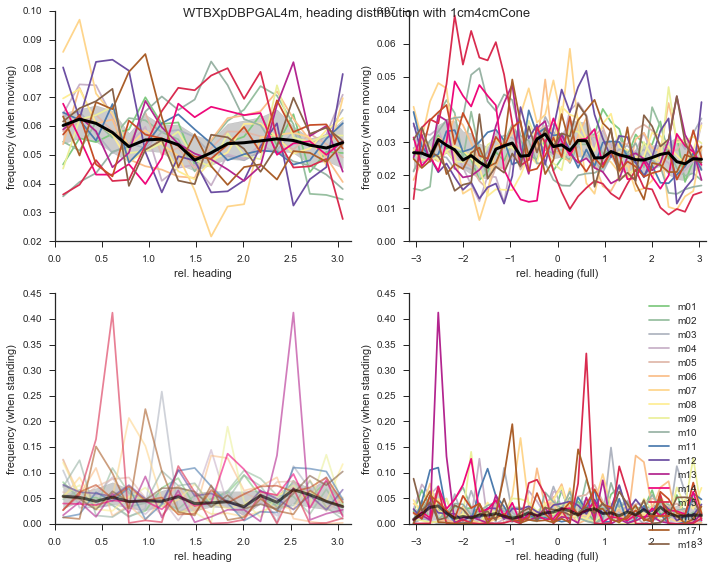

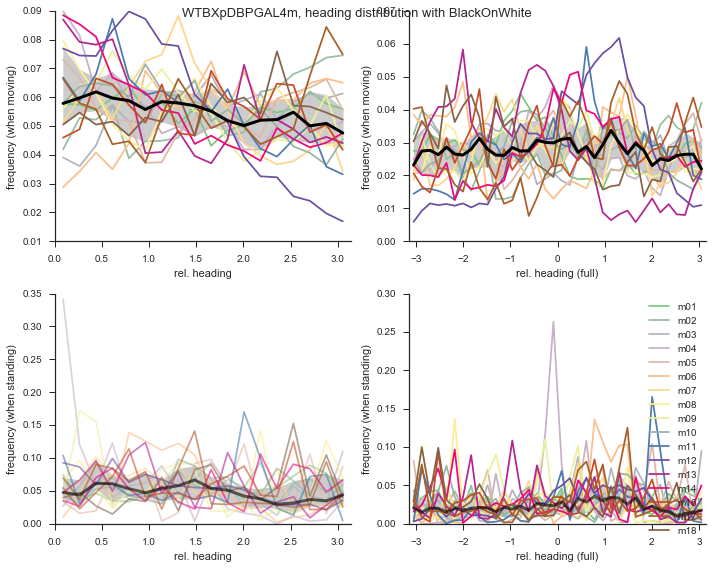

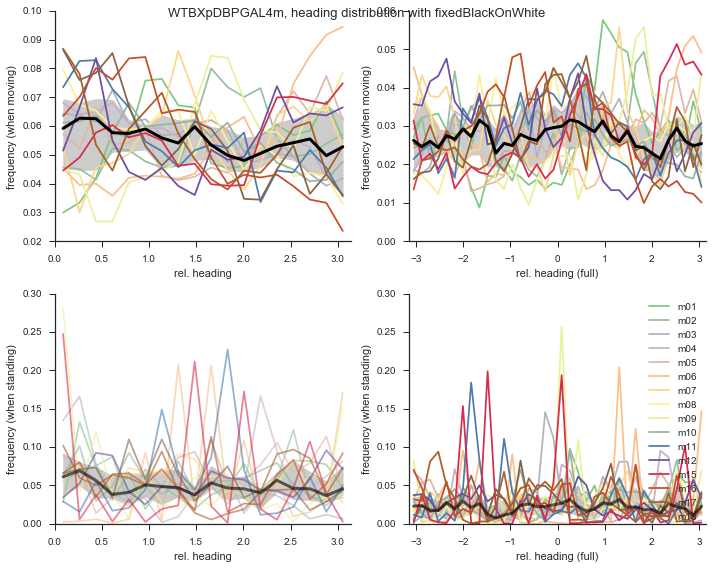

In [70]:
for scene in range(len(sceneNames)):

    scenename = sceneNames[scene]
    print(scenename)
    densityFlag = True
    titleString = genotypeSex+', heading distribution with '+ scenename

    headingfig = plotHeadingComparison(scenename,titleString,densityFlag,True, flyIDs,
                                       FOAllFlies_df,keyind_gam, keyind_gamful, keyind_mov)

    headingfig.savefig(analysisDir + sep + 'heading' + sep + genotypeSex + '_headingDistribution_'+scenename+'_medianIQR_n'+str(numFlies)+'.pdf', format = 'pdf')

1cm4cmCone
BlackOnWhite
fly m15 not moving: 12.125
fixedBlackOnWhite
fly m13 not moving: 14.425
fly m14 not moving: 12.7666666667


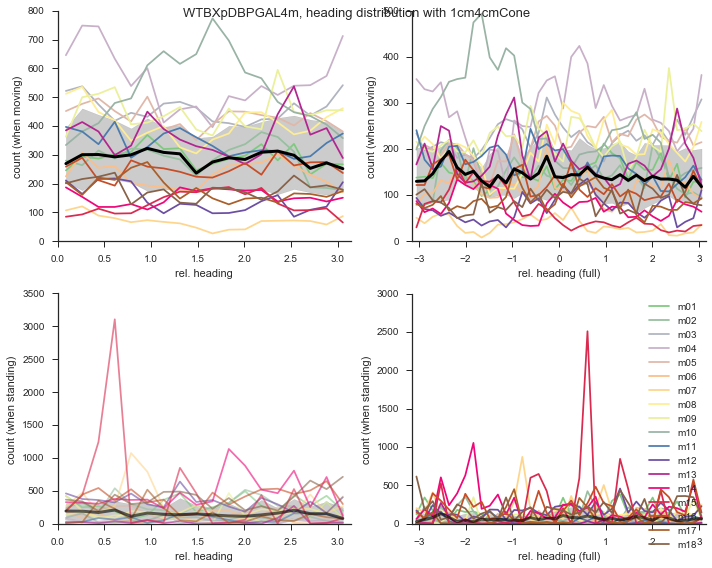

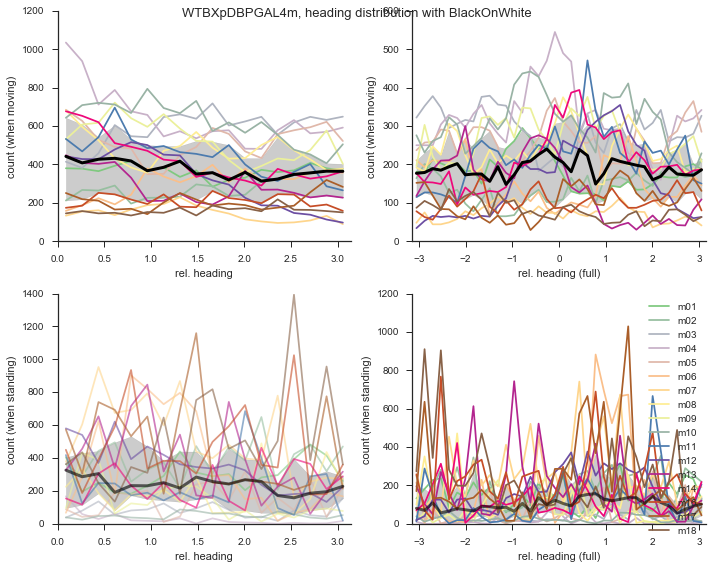

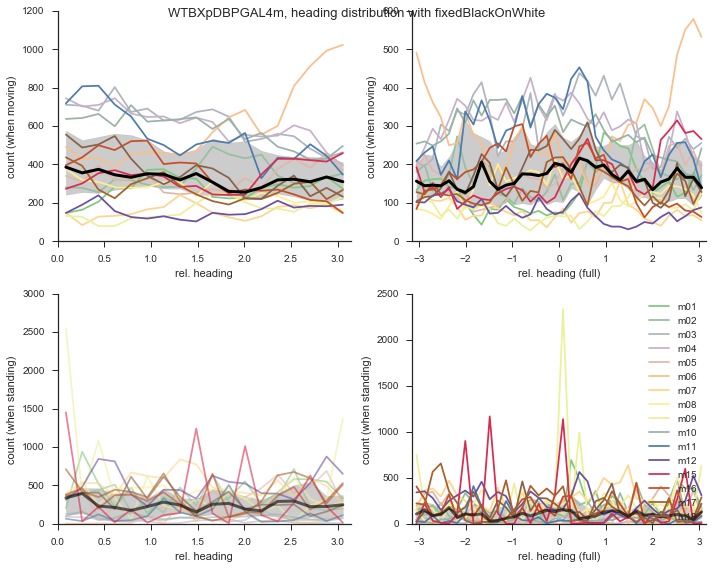

In [71]:
for scene in range(len(sceneNames)):
    headingfig = plt.figure(figsize=(10,8))

    scenename = sceneNames[scene]
    print(scenename)
    
    densityFlag = False
    titleString = genotypeSex+', heading distribution with '+ scenename

    headingfig = plotHeadingComparison(scenename,titleString,densityFlag,True, flyIDs, FOAllFlies_df,
                                       keyind_gam, keyind_gamful, keyind_mov)

    headingfig.savefig(analysisDir + sep + 'heading' + sep + genotypeSex + '_headingCounts_'+scenename+'_medianIQR_n'+str(numFlies)+'.pdf', format = 'pdf')

## Comparison between relative heading and absolute heading in 2D worlds (they are the same in 1D)

In [72]:
def plot2DHeadingComparison(sceneName,titleString,densityFlag,plotIQR):
    legendlist = []
    fullBins = 36
    histRange = (-np.pi, np.pi)

    nhead_angle = np.nan*np.ones((numFlies,fullBins))
    nhead_gamma = np.nan*np.ones((numFlies,fullBins))
    
    gammaPlt = headingfig.add_subplot(121)
    
    for fly in range(numFlies):
        querystring = '(sceneName=="' + sceneName + '") & (flyID =="' + flyIDs[fly] +  '")'

        gammaFull = FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1].squeeze()
        angle = FOAllFlies_df.query(querystring).iloc[:,keyind_ang:keyind_ang+1].squeeze()

        moving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze()
        
        if sum(moving)<=0.2*len(moving):
            print('fly '+str(flyIDs[fly])+' not moving: '+  str(100.0*sum(moving)/max(1,len(moving))))
            continue
            
        legendlist.append(flyIDs[fly])
        
        if densityFlag:
            ylab = 'frequency (when moving)'
        else:
            ylab = 'count (when moving)'
        
        # rel. heading
        gammaPlt, normgam, fulledges = plotHeadingDistFromTimeseries(gammaPlt, gammaFull[moving > 0], densityFlag,
                                                                     histRange, fullBins, flyCMap.to_rgba(fly),
                                                                     'rel. heading', ylab, 1)
        nhead_gamma[fly, :] = normgam

        # abs. heading
        anglePlt = headingfig.add_subplot(122)
        
        anglePlt, normang, fulledges = plotHeadingDistFromTimeseries(anglePlt, angle[moving > 0], densityFlag, 
                                                                     histRange, fullBins, flyCMap.to_rgba(fly), 
                                                                     'abs. heading', ylab, 1)

        nhead_angle[fly,:] = normang

    headingfig.suptitle(titleString,fontsize=13)
    anglePlt.legend(legendlist)
    headingfig.tight_layout()
    
    gammaPlt.plot(fulledges,np.nanmedian(nhead_gamma[:,:],0),color='k',linewidth=3)
    anglePlt.plot(fulledges,np.nanmedian(nhead_angle[:,:],0),color='k',linewidth=3)
    
    if(plotIQR):
        [var1,var2] = np.nanpercentile(nhead_gamma[:,:],[25,75],axis=0)
        gammaPlt.fill_between(fulledges, var1, var2, color='k', alpha=0.2)
        
        [var1,var2] = np.nanpercentile(nhead_angle[:,:],[25,75],axis=0)
        anglePlt.fill_between(fulledges, var1, var2, color='k', alpha=0.2)

    return headingfig

1cm4cmCone

BlackOnWhite

fly m15 not moving: 12.125
fixedBlackOnWhite

fly m13 not moving: 14.425
fly m14 not moving: 12.7666666667


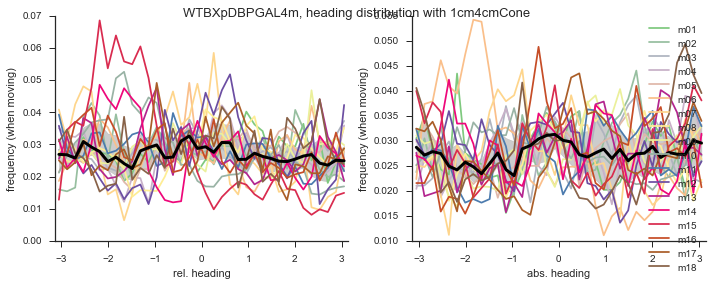

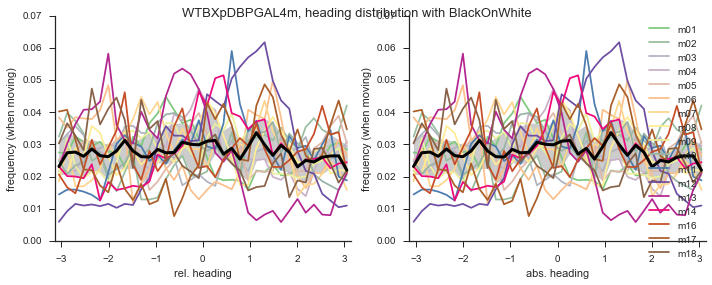

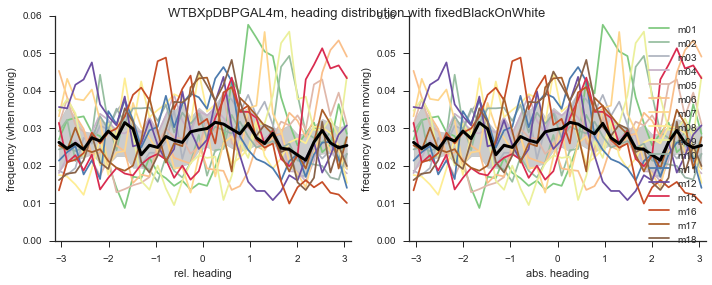

In [73]:
for scene in [0,1,2]:
    headingfig = plt.figure(figsize=(10,4))

    scenename = sceneNames[scene]
    print(scenename+'\n')
    densityFlag = True
    titleString = genotypeSex+', heading distribution with '+ scenename

    headingfig = plot2DHeadingComparison(scenename,titleString,densityFlag,True)

    headingfig.savefig(analysisDir + sep + 'heading' + sep + genotypeSex + '_headingDistribution_'+scenename+'_medianIQR_n'+str(numFlies)+'.pdf', format = 'pdf')

## Compute circular statistics on heading distribution

In [74]:
angleLow = -np.pi
angleHigh = np.pi

headingPVA = np.nan*np.ones((len(sceneNames),numFlies,2))
anglePVA = np.nan*np.ones((len(sceneNames),numFlies,2))
fliesNotWalking = np.zeros((len(sceneNames)))

from scipy.stats import circmean as circmean

for scene in range(len(sceneNames)):
    scenename = sceneNames[scene]
    print('\n'+scenename+'\n')
    
    for fly in range(numFlies):

        querystring = '(sceneName=="' + scenename + '") & (flyID =="' + flyIDs[fly] +  '")'
        moving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze().astype('int').values

        perFlyG = FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1].squeeze().astype('float').values
        perFlyA = FOAllFlies_df.query(querystring).iloc[:,keyind_ang:keyind_ang+1].squeeze().astype('float').values

        if sum(moving)<=0.2*len(moving):
            print('fly '+str(flyIDs[fly])+' not moving: '+str(100.0*sum(moving)/max(1,len(moving))))
            fliesNotWalking[scene] += 1
            
            continue
        gamFul = perFlyG[moving>0]
        meandir, meanlen = circmeanvec(gamFul[~np.isnan(gamFul)],np.ones(len(gamFul[~np.isnan(gamFul)])), high=angleHigh, low=angleLow)

        headingPVA[scene,fly,0] = meandir
        headingPVA[scene,fly,1] = meanlen
        
        angle = perFlyA[moving>0]
        meandir, meanlen = circmeanvec(angle[~np.isnan(angle)],np.ones(len(angle[~np.isnan(angle)])), high=angleHigh, low=angleLow)

        anglePVA[scene,fly,0] = meandir
        anglePVA[scene,fly,1] = meanlen
        
try:
    mkdir(analysisDir + sep + 'circStats' + sep)
except OSError:
    print('Analysis directory already exists.')
        
np.savetxt(analysisDir + 'circStats/'  + genotype + '_headingPVA_dir_'+scenename+'_n'+ str(numFlies) +'.csv',
           headingPVA[:,:,0], delimiter=',')
np.savetxt(analysisDir + 'circStats/'  + genotype + '_headingPVA_len_'+scenename+'_n'+ str(numFlies) +'.csv',
           headingPVA[:,:,1], delimiter=',')
np.savetxt(analysisDir + 'circStats/'  + genotype + '_anglePVA_dir_'+scenename+'_n'+ str(numFlies) +'.csv',
           anglePVA[:,:,0], delimiter=',')
np.savetxt(analysisDir + 'circStats/'  + genotype + '_anglePVA_len_'+scenename+'_n'+ str(numFlies) +'.csv',
           anglePVA[:,:,1], delimiter=',')


1cm4cmCone


BlackOnWhite

fly m15 not moving: 12.125

fixedBlackOnWhite

fly m13 not moving: 14.425
fly m14 not moving: 12.7666666667
Analysis directory already exists.


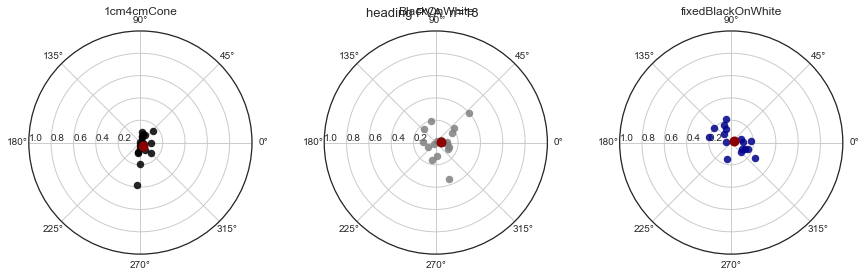

In [75]:
trialCol = ['black','grey','darkblue','steelblue']

PVAFig = plt.figure(figsize=(15,4))

for scene in range(len(sceneNames)):
    scenename = sceneNames[scene]    

    ax = PVAFig.add_subplot(1,len(sceneNames),scene+1,projection='polar')
    ax.plot(headingPVA[scene,:,0],headingPVA[scene,:,1],'.',markersize=15,color=trialCol[scene],alpha=0.85)
    meandir, meanlen = circmeanvec(headingPVA[scene,~np.isnan(headingPVA[scene,:,0]),0],\
                                   headingPVA[scene,~np.isnan(headingPVA[scene,:,0]),1],\
                                   high=angleHigh, low=angleLow)
    ax.plot(meandir,meanlen,'o', color='darkred',alpha=1, markersize=10)
    ax.set_rlim(0,1)
    ax.set_rlabel_position(180)
    ax.set_title(scenename)

PVAFig.suptitle('heading PVA, n='+str(numFlies),fontsize=13)
PVAFig.savefig(analysisDir + 'circStats/'  + genotype
                + '_headingPVA_n'+ str(numFlies) +'.pdf', format='pdf') 

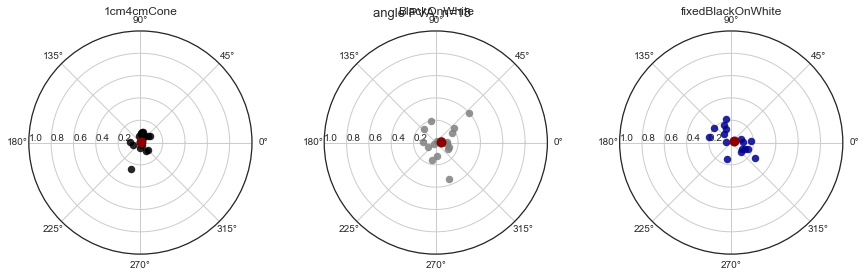

In [76]:
PVAFig = plt.figure(figsize=(15,4))

for scene in range(len(sceneNames)):
    scenename = sceneNames[scene]    

    ax = PVAFig.add_subplot(1,len(sceneNames),scene+1,projection='polar')
    ax.plot(anglePVA[scene,:,0],anglePVA[scene,:,1],'.',markersize=15,color=trialCol[scene],alpha=0.85)
    meandir, meanlen = circmeanvec(anglePVA[scene,~np.isnan(anglePVA[scene,:,0]),0],\
                                   anglePVA[scene,~np.isnan(anglePVA[scene,:,0]),1],\
                                   high=angleHigh, low=angleLow)
    ax.plot(meandir,meanlen,'o', color='darkred',alpha=1, markersize=10)
    ax.set_rlim(0,1)
    ax.set_rlabel_position(180)
    ax.set_title(scenename)

PVAFig.suptitle('angle PVA, n='+str(numFlies),fontsize=13)
PVAFig.savefig(analysisDir + 'circStats/'  + genotype
                + '_anglePVA_n'+ str(numFlies) +'.pdf', format='pdf') 

## Fit von Mises distribution

In [77]:
from scipy import stats as sts
from scipy.optimize import curve_fit

def sineFunc(x, a, b):
    y = (np.sin((x-a))*b) + b
    y = y/sum(y*np.mean(np.diff(x)))
    return y

def vMFunc(x, mu, kappa):
    return np.exp(kappa * np.cos(x-mu)) / (2*np.pi*np.i0(kappa))

def vMbiModFunc(x, mu1, mu2, kappa):
    return ( (np.exp(kappa * np.cos(x-mu1)) / (2*np.pi*np.i0(kappa))) + (np.exp(kappa * np.cos(x-mu2)) / (2*np.pi*np.i0(kappa))) )/2

In [78]:
def plotOneTrialHeading(ax1, ax2, gammaful, time, meandir, meanlen):
    ax1.plot(time, gammaful)
    ax1.set_ylim(angleLow, angleHigh)
    ax1.set_xlim(0,600)
    myAxisTheme(ax1)
    
    ax2.plot(meandir, meanlen,'.',markersize=15,color='steelblue',alpha=0.85)
    ax2.set_rlim(0,0.8)
    ax2.set_rlabel_position(180)
    ax2.set_title('heading PVA, ' + sceneName + ', n='+str(numFlies))

[ 0.87730854  0.07528814]


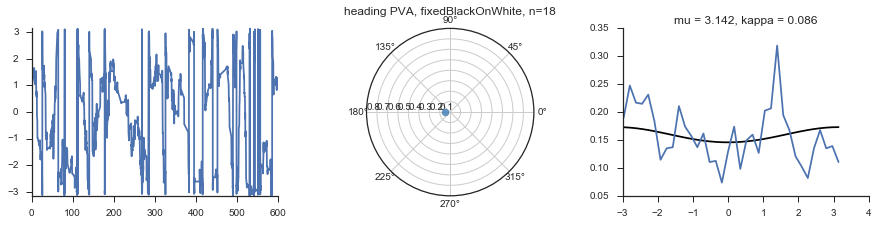

In [79]:
sceneName = sceneNames[2]
fly = 6

querystring = '(sceneName=="' + sceneName + '") & (flyID =="' + flyIDs[fly] +  '")'
moving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze().astype('int').values

perFlyG = FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1].squeeze().astype('float').values
perFlyT = FOAllFlies_df.query(querystring).iloc[:,keyind_t:keyind_t+1].squeeze().astype('float').values
if sum(moving)<=0.2*len(moving):
    print('fly '+str(flyIDs[fly])+' not moving: '+str(100.0*sum(moving)/max(1,len(moving))))

gamFul = perFlyG[moving>0]
time = perFlyT[moving>0]
meandir, meanlen = circmeanvec(gamFul[~np.isnan(gamFul)],np.ones(len(gamFul[~np.isnan(gamFul)])), high=angleHigh, low=angleLow)

bins = np.linspace(angleLow, angleHigh, 37)
x = bins[:-1] + np.mean(np.diff(bins))
[n,edg] = np.histogram(gamFul,bins, normed=True)

meandir_freq, meanlen_freq = circmeanvec(n,np.ones(len(n)), high=angleHigh, low=angleLow)

popt, pcov = curve_fit(vMFunc, x, n, p0=[meandir_freq, meanlen_freq], bounds=([-np.pi, 0], [np.pi, np.inf]))
perr = np.sqrt(np.diag(pcov))
print(perr)

mu = popt[0]
kappa = popt[1]
yhat = vMFunc(x,mu,kappa)

fitFig = plt.figure(figsize=(15,3))
plotOneTrialHeading(fitFig.add_subplot(131),fitFig.add_subplot(132,projection='polar'), gamFul, time, meandir, meanlen)

ax3 = fitFig.add_subplot(133)   
ax3.plot(x,yhat,'k')
ax3.plot(x,n)
ax3.set_title('mu = '+str(round(mu,3))+', kappa = '+str(round(kappa,3)))
myAxisTheme(ax3)

[ 0.25033847  0.25033846  0.18753474]


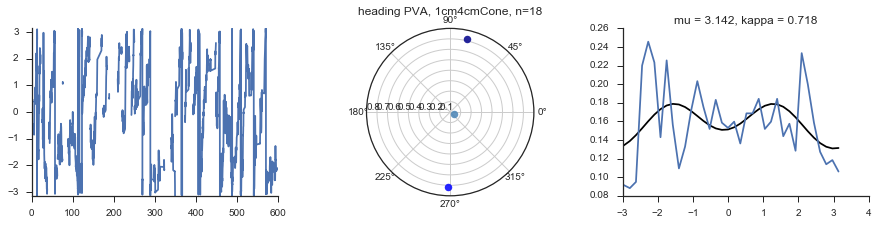

In [80]:
sceneName = sceneNames[0]
fly = 1

querystring = '(sceneName=="' + sceneName + '") & (flyID =="' + flyIDs[fly] +  '")'
moving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze().astype('int').values

perFlyG = FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1].squeeze().astype('float').values
perFlyT = FOAllFlies_df.query(querystring).iloc[:,keyind_t:keyind_t+1].squeeze().astype('float').values

if sum(moving)<=0.2*len(moving):
    print('fly '+str(flyIDs[fly])+' not moving: '+str(100.0*sum(moving)/max(1,len(moving))))

gamFul = perFlyG[moving>0]
time = perFlyT[moving>0]
meandir, meanlen = circmeanvec(gamFul[~np.isnan(gamFul)],np.ones(len(gamFul[~np.isnan(gamFul)])), high=angleHigh, low=angleLow)

bins = np.linspace(angleLow, angleHigh, 37)
x = bins[:-1] + np.mean(np.diff(bins))
[n,edg] = np.histogram(gamFul,bins, normed=True)

meandir_freq, meanlen_freq = circmeanvec(n,np.ones(len(n)), high=angleHigh, low=angleLow)

popt, pcov = curve_fit(vMbiModFunc, x, n , p0=[-np.pi/2, np.pi/2, meanlen_freq], bounds=([-np.pi, -np.pi, 0], [np.pi, np.pi, np.inf]))
perr = np.sqrt(np.diag(pcov))
print(perr)

mu1 = popt[0]
mu2 = popt[1]
kappa = popt[2]

yhat = vMbiModFunc(x, mu1, mu2, kappa)

fitFig = plt.figure(figsize=(15,3))
ax1 = fitFig.add_subplot(131)
ax2 = fitFig.add_subplot(132,projection='polar')
plotOneTrialHeading(ax1, ax2, gamFul, time, meandir, meanlen)

ax2.plot(mu1, kappa,'.',markersize=15,color='blue',alpha=0.85)
ax2.plot(mu2, kappa,'.',markersize=15,color='darkblue',alpha=0.85)

ax3 = fitFig.add_subplot(133)
ax3.plot(x,yhat,'k')
ax3.plot(x,n)
ax3.set_title('mu = '+str(round(mu,3))+', kappa = '+str(round(kappa,3)))
myAxisTheme(ax3)

### Fit unimodal von Mises

fly m15 not moving: 12.125
fly m13 not moving: 14.425
fly m14 not moving: 12.7666666667


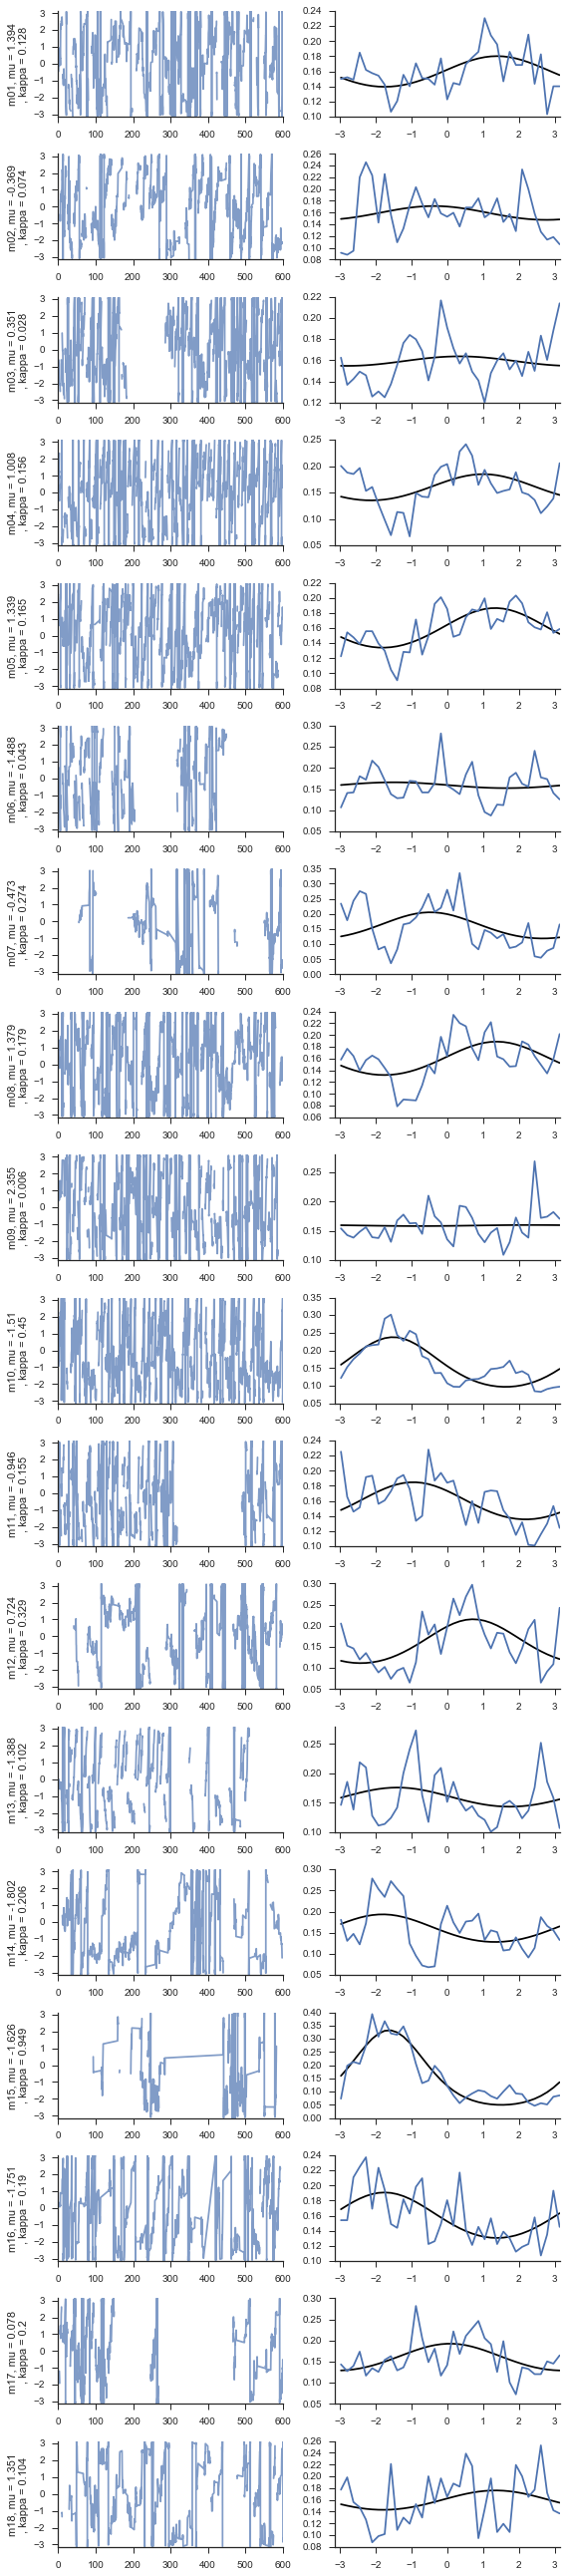

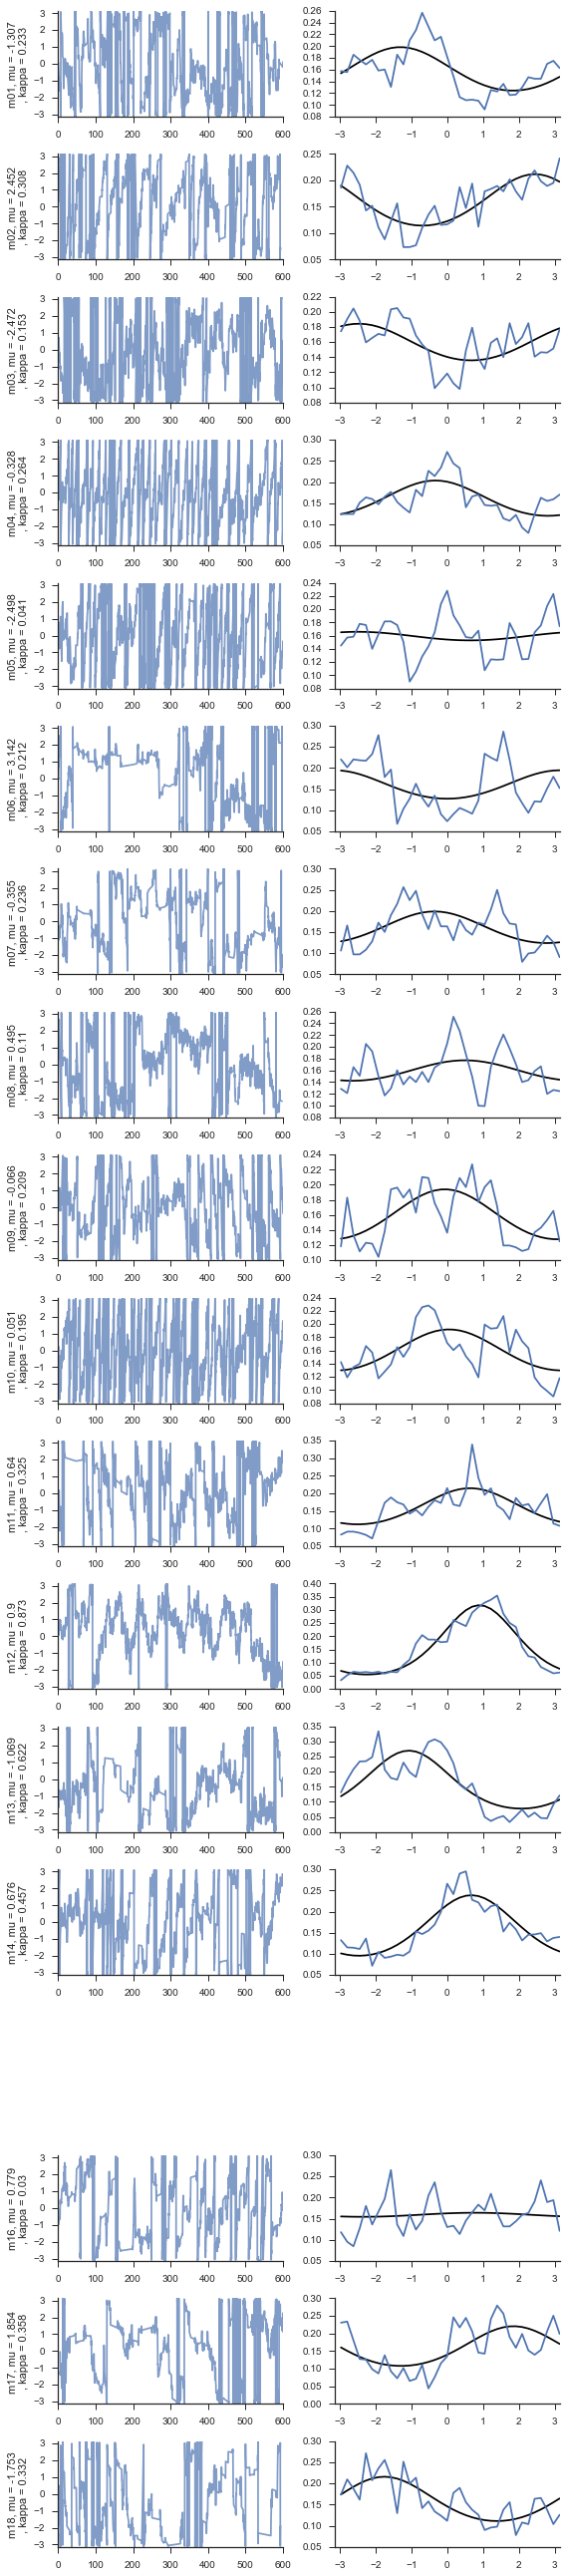

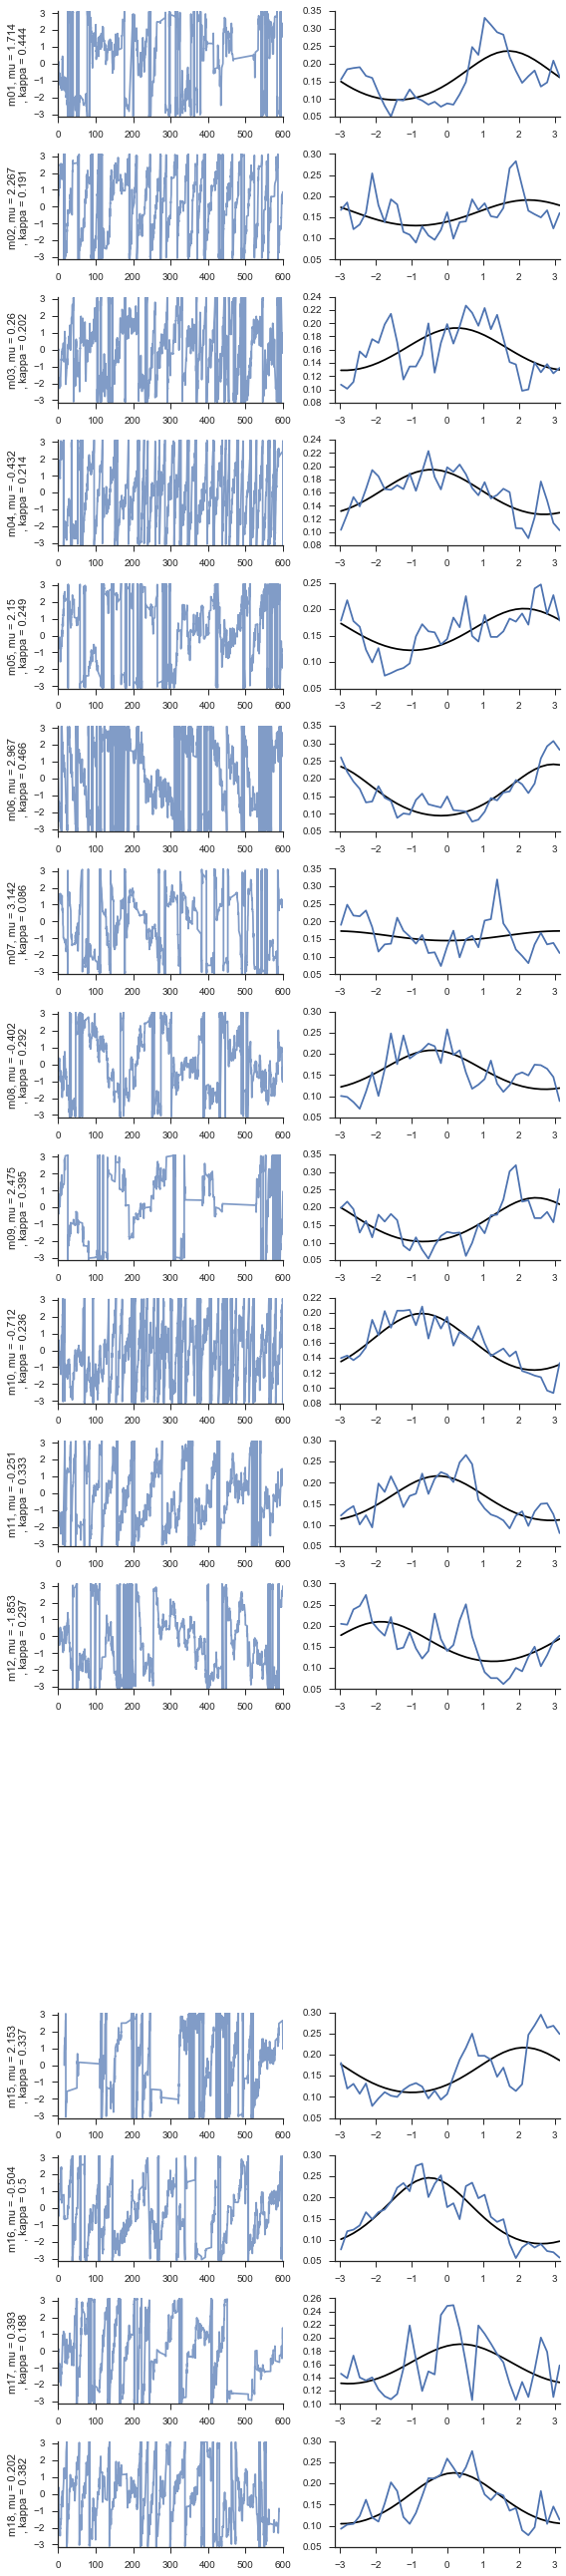

In [81]:
angleLow = -np.pi
angleHigh = np.pi

#bins size
binwidth = 10 #deg
numFlies = len(flyIDs)
vmfits = np.nan*np.ones((len(sceneNames),5,numFlies))

for scene in range(len(sceneNames)):
    sceneName = sceneNames[scene]
    fitFig = plt.figure(figsize=(8,2*numFlies))
    
    for fly in range(numFlies):
        querystring = '(sceneName=="' + sceneName + '") & (flyID =="' + flyIDs[fly] +  '")'
        moving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze().astype('int').values

        perFlyG = FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1].squeeze().astype('float').values
        perFlyT = FOAllFlies_df.query(querystring).iloc[:,keyind_t:keyind_t+1].squeeze().astype('float').values

        if sum(moving)<=0.2*len(moving):
            print('fly '+str(flyIDs[fly])+' not moving: '+str(100.0*sum(moving)/max(1,len(moving))))

            continue

        gamFul = perFlyG[moving>0]
        time = perFlyT[moving>0]
        
        bins = np.linspace(angleLow,angleHigh, 360/binwidth + 1)
        x = bins[:-1] + np.mean(np.diff(bins))
        [n,edg] = np.histogram(gamFul,bins, normed=True)
        meandir_freq, meanlen_freq = circmeanvec(n,np.ones(len(n)), high=angleHigh, low=angleLow)

        popt, pcov = curve_fit(vMFunc, x, n, p0=[meandir_freq, meanlen_freq], bounds=([-np.pi, 0], [np.pi, np.inf]))
        mu = popt[0]
        kappa = popt[1]
        yhat = vMFunc(x,mu,kappa)

        #compute kolmogorov-smirnov statistic as measure of goodness of fit
        [ks, p] = sts.ks_2samp(n, yhat)

        #compute squared difference from fit
        sqd = np.sum(np.square(n-yhat))

        vmfits[scene,0,fly] = mu
        vmfits[scene,1,fly] = kappa
        vmfits[scene,2,fly] = sqd
        vmfits[scene,3,fly] = p
        vmfits[scene,4,fly] = ks

        #plot fit results
        ax = fitFig.add_subplot(numFlies,2,1+fly*2)
        ax.plot(time, gamFul,alpha=0.7)
        ax.set_xlim(0,600)
        ax.set_ylim(angleLow,angleHigh)
        ax.set_ylabel(str(flyIDs[fly])+', mu = '+str(round(mu,3)) +'\n, kappa = '+str(round(kappa,3)))
        myAxisTheme(ax)

        ax = fitFig.add_subplot(numFlies,2,2+fly*2)
        ax.plot(x,yhat,'k')
        ax.plot(x,n)
        ax.set_xlim(angleLow,angleHigh)
        myAxisTheme(ax)

    fitFig.tight_layout()

    fitFig.savefig(analysisDir + 'circStats/'  + genotype + '_' + sceneName
                   + '_vMFit_n'+ str(numFlies) +'.pdf', format='pdf') 

1cm4cmCone
flies with heading distribution that is significantly different from von Mieses fit (KS test):
['m02', 'm03', 'm04', 'm06', 'm07', 'm09', 'm12', 'm13', 'm14', 'm18']
flies with large summed squared error:
['m07', 'm12', 'm14']
BlackOnWhite
flies with heading distribution that is significantly different from von Mieses fit (KS test):
['m05', 'm06', 'm08', 'm09', 'm13', 'm16']
flies with large summed squared error:
['m06', 'm13', 'm17']
fixedBlackOnWhite
flies with heading distribution that is significantly different from von Mieses fit (KS test):
['m07']
flies with large summed squared error:
['m01', 'm07']


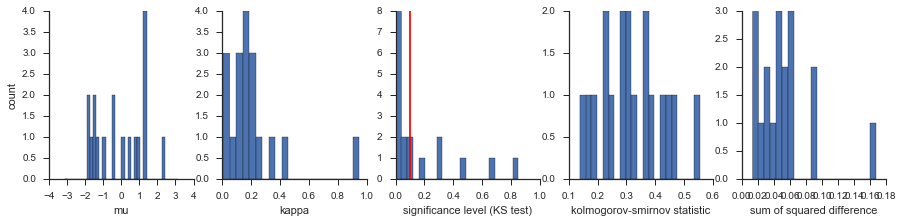

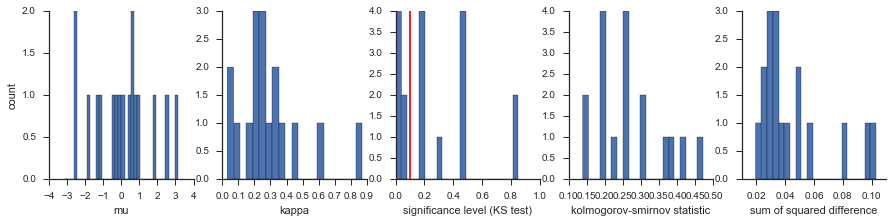

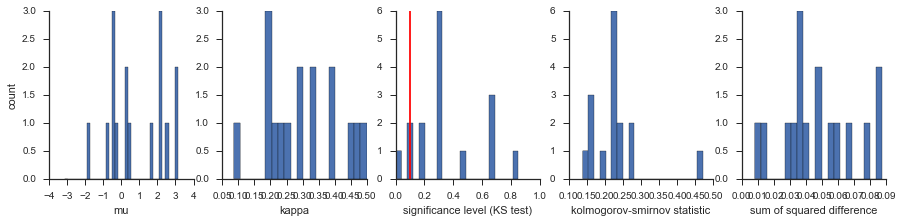

In [82]:
for scene in range(len(sceneNames)):
    sceneName = sceneNames[scene]
    fitFig = plt.figure(figsize=(15,3))

    bins = np.linspace(-np.pi, np.pi, 360/binwidth + 1)

    muax = fitFig.add_subplot(151)
    muax.hist(vmfits[scene,0,~np.isnan(vmfits[scene,0,:])],bins)
    #muax.set_xlim(-np.pi, np.pi)
    muax.set_ylabel('count')
    muax.set_xlabel('mu')
    myAxisTheme(muax)

    bins = np.linspace(0, 2, 21)
    kapax = fitFig.add_subplot(152)
    kapax.hist(vmfits[scene,1,~np.isnan(vmfits[scene,1,:])],len(bins))
    #kapax.set_xlim(0, 2)
    kapax.set_xlabel('kappa')
    myAxisTheme(kapax)

    bins = np.linspace(0, 1, 21)
    pax = fitFig.add_subplot(153)
    pax.hist(vmfits[scene,3,~np.isnan(vmfits[scene,3,:])],len(bins))
    pax.set_xlim(0, 1)
    pax.axvline(0.1,color='red')
    pax.set_xlabel('significance level (KS test)')

    bins = np.linspace(0, 1, 21)
    ksax = fitFig.add_subplot(154)
    ksax.hist(vmfits[scene,4,~np.isnan(vmfits[scene,4,:])],len(bins))
    #ksax.set_xlim(0, 1)
    ksax.set_xlabel('kolmogorov-smirnov statistic')
    myAxisTheme(ksax)

    bins = np.linspace(0, 1, 21)
    ksax = fitFig.add_subplot(155)
    ksax.hist(vmfits[scene,2,~np.isnan(vmfits[scene,2,:])],len(bins))
    #ksax.set_xlim(0, 1)
    ksax.set_xlabel('sum of squared difference')
    myAxisTheme(ksax)

    print(sceneName)
    print('flies with heading distribution that is significantly different from von Mieses fit (KS test):')
    print([flyIDs[fly] for fly in np.where(vmfits[scene,3,:]<=0.1)[0]])

    print('flies with large summed squared error:')
    print([flyIDs[fly] for fly in np.where(vmfits[scene,2,:]>=0.08)[0]])

    myAxisTheme(pax)

    fitFig.savefig(analysisDir + 'circStats/'  + genotype + '_' + sceneName
                   + '_vMFitDistributions_n'+ str(numFlies) +'.pdf', format='pdf') 

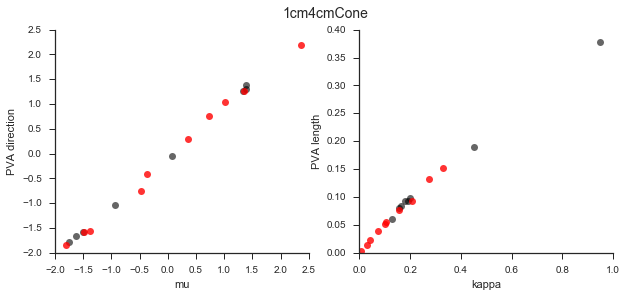

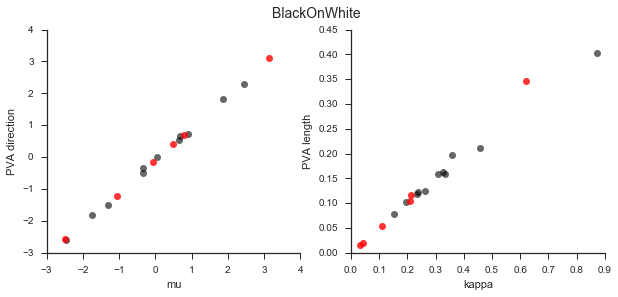

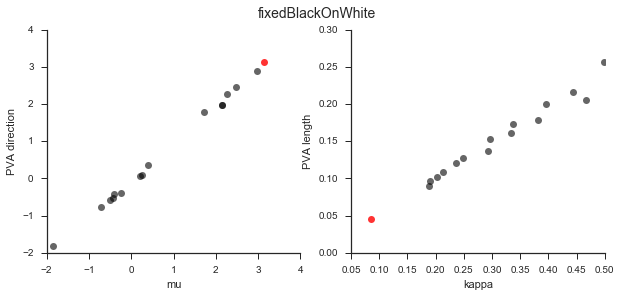

In [83]:
# Correlation between von Mieses fit and PVA
#Plot fit results
for scene in range(len(sceneNames)):
    sceneName = sceneNames[scene]
    corrFig = plt.figure(figsize=(10,4))
    corrFig.suptitle(sceneName,fontsize=14)

    notFit = np.logical_and(np.logical_and(vmfits[scene,3,:]<=0.1, headingPVA[scene,:,1]<0.5),\
                            ~np.isnan(headingPVA[scene,:,1]))

    #correlation between mu and PVA direction
    muax = corrFig.add_subplot(121)
    muax.plot(vmfits[scene,0,~notFit],headingPVA[scene,~notFit,0],'ko',alpha=0.6)
    muax.plot(vmfits[scene,0,notFit],headingPVA[scene,notFit,0],'ro',alpha=0.8)
    muax.set_xlabel('mu'); muax.set_ylabel('PVA direction');
    myAxisTheme(muax)

    #correlation between kappa and PVA length
    kapax = corrFig.add_subplot(122)
    kapax.plot(vmfits[scene,1,~notFit],headingPVA[scene,~notFit,1],'ko',alpha=0.6)
    kapax.plot(vmfits[scene,1,notFit],headingPVA[scene,notFit,1],'ro',alpha=0.8)
    kapax.set_xlabel('kappa'); kapax.set_ylabel('PVA length');
    myAxisTheme(kapax)

    corrFig.savefig(analysisDir + 'circStats/'  + genotype + '_' + sceneName
                   + '_vM-vs-PVA_n'+ str(numFlies) +'.pdf', format='pdf') 

problem with sample
nan
problem with sample
nan


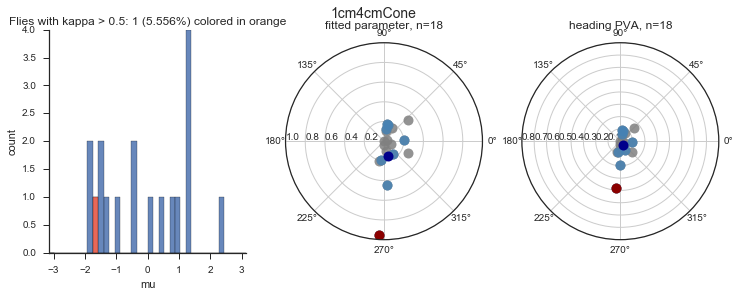

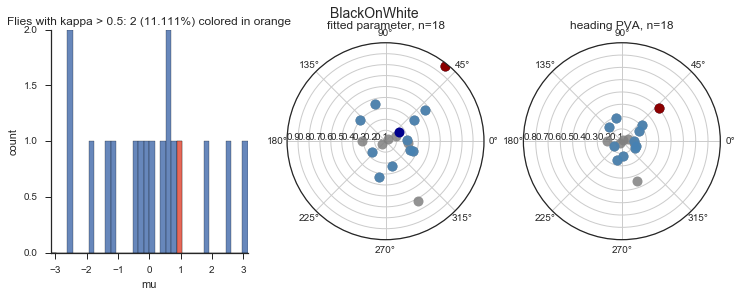

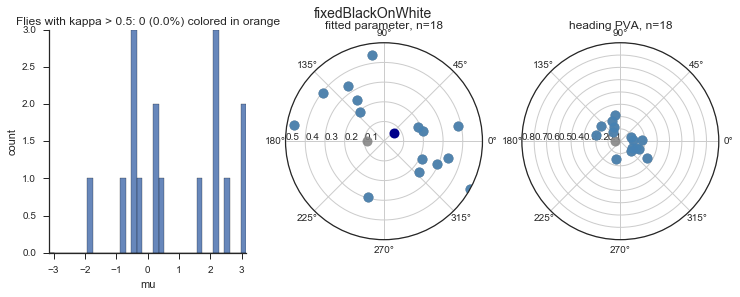

In [84]:
# number of flies with fitted von Mises with Kappa > 0.5 (disregarding also the flies that were not well represented by
# von Mises fit)

kappaTH = 0.5

for scene in range(len(sceneNames)):
    sceneName = sceneNames[scene]
    goodFit = np.logical_and(np.logical_or(vmfits[scene,3,:]>0.1, headingPVA[scene,:,1]>0.5),\
                              ~np.isnan(headingPVA[scene,:,1]))

    slct = np.logical_and(vmfits[scene,1,:]>kappaTH,goodFit)

    bins = np.linspace(-np.pi, np.pi, 360/binwidth + 1)

    x = bins[:-1] + np.mean(np.diff(bins))
    [n,edg] = np.histogram(vmfits[scene,0,~np.isnan(vmfits[scene,0,:])],bins)
    [n_slct,edg] = np.histogram(vmfits[scene,0,slct],bins)

    #Plot fit results
    fixFig = plt.figure(figsize=(12,4))
    fixFig.suptitle(sceneName,fontsize=14)

    #histogram of fitted location (mu)
    muax = fixFig.add_subplot(131)
    muax.hist(vmfits[scene,0,~np.isnan(vmfits[scene,0,:])],bins,alpha=0.85)
    muax.hist(vmfits[scene,0,slct],bins,color='tomato',alpha=0.85)
    muax.set_xlim(-np.pi, np.pi)
    muax.set_xlabel('mu')
    muax.set_ylabel('count')
    muax.set_title('Flies with kappa > '+str(kappaTH)+': '+str(sum(vmfits[scene,1,:]>kappaTH))+' ('+\
                   str(round(100.0*sum(vmfits[scene,1,:]>kappaTH)/float(numFlies),3))+'%) colored in orange')
    myAxisTheme(muax)
    
    #polar plot of fitted location and shape parameter
    ax = fixFig.add_subplot(132,projection='polar')
    ax.plot(vmfits[scene,0,:],vmfits[scene,1,:],'o',markersize=10,color='grey',alpha=0.85)
    ax.plot(vmfits[scene,0,goodFit],vmfits[scene,1,goodFit],'o',markersize=10,color='steelblue',alpha=0.85)
    meandir, meanlen = circmeanvec(vmfits[scene,0,goodFit],vmfits[scene,1,goodFit], high=angleHigh, low=angleLow)
    ax.plot(meandir,meanlen,'o', color='darkblue',alpha=1, markersize=10)
    ax.plot(vmfits[scene,0,slct],vmfits[scene,1,slct],'.',markersize=12,color='tomato',alpha=0.85)
    meandir, meanlen = circmeanvec(vmfits[scene,0,slct],vmfits[scene,1,slct], high=angleHigh, low=angleLow)
    ax.plot(meandir,meanlen,'o', color='darkred',alpha=1, markersize=10)
    #ax.set_rlim(0,1)
    ax.set_rlabel_position(180)
    ax.set_title('fitted parameter, n='+str(numFlies))

    #polar plot of PVA
    ax = fixFig.add_subplot(133,projection='polar')
    ax.plot(headingPVA[scene,:,0],headingPVA[scene,:,1],'o',markersize=10,color='grey',alpha=0.85)
    ax.plot(headingPVA[scene,goodFit,0],headingPVA[scene,goodFit,1],'o',markersize=10,color='steelblue',alpha=0.85)
    meandir, meanlen = circmeanvec(headingPVA[scene,:,0],headingPVA[scene,:,1], high=angleHigh, low=angleLow)
    ax.plot(meandir,meanlen,'o', color='darkblue',alpha=1, markersize=10)

    ax.plot(headingPVA[scene,slct,0],headingPVA[scene,slct,1],'.',markersize=12,color='tomato',alpha=0.85)
    meandir, meanlen = circmeanvec(headingPVA[scene,slct,0],headingPVA[scene,slct,1], high=angleHigh, low=angleLow)
    ax.plot(meandir,meanlen,'o', color='darkred',alpha=1, markersize=10)
    ax.set_rlim(0,0.8)
    ax.set_rlabel_position(180)
    ax.set_title('heading PVA, n='+str(numFlies))
    
    #fixFig.tight_layout()
    fixFig.savefig(analysisDir + 'circStats/'  + genotype + '_' + sceneName
                   + '_vMFixation_n'+ str(numFlies) +'.pdf', format='pdf') 

### Fit bimodal von Mises to those distributions for which no good unimodal fit was found

1cm4cmCone
m02
m03
m04
m06
m07
m09
m12
m13
m14
m18
BlackOnWhite
m05
m06
m08
m09
m13
m16
fixedBlackOnWhite
m07


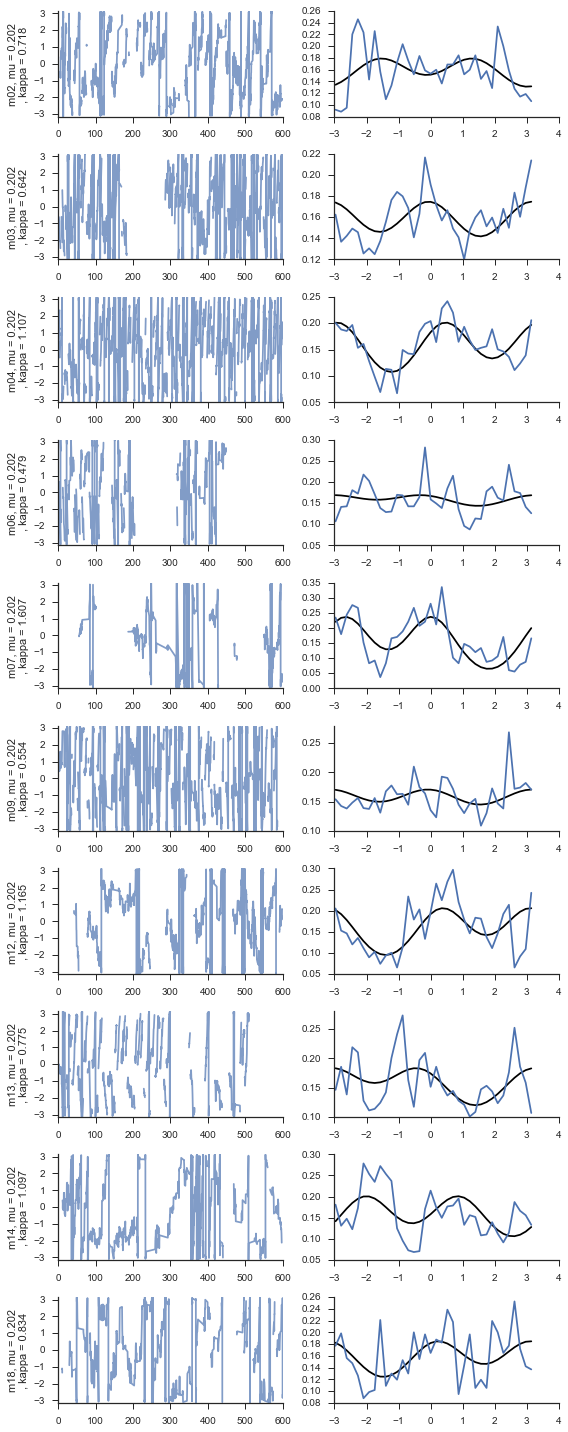

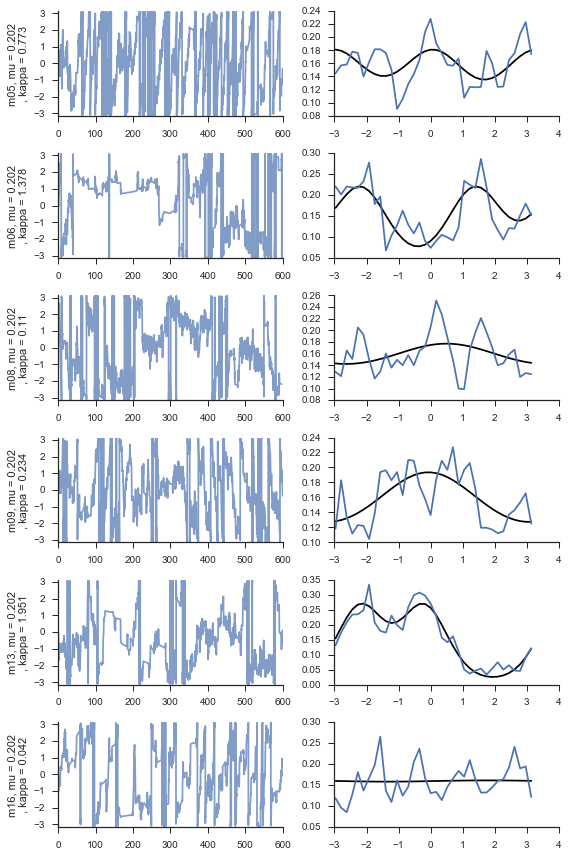

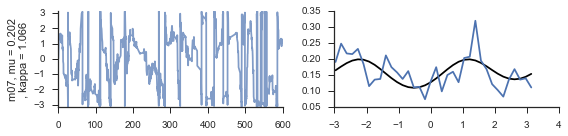

In [85]:
angleLow = -np.pi
angleHigh = np.pi

#bins size
binwidth = 10 #deg
numFlies = len(flyIDs)
vmbmfits = np.nan*np.ones((len(sceneNames),6,numFlies))

for scene, sceneName in enumerate(sceneNames):
    print(sceneName)
    
    noFit = np.logical_and(np.logical_and(vmfits[scene,3,:]<=0.1, headingPVA[scene,:,1]<0.5),\
                             ~np.isnan(headingPVA[scene,:,1]))
    
    notGoodFit = np.where(noFit>0)[0]
    
    if(len(notGoodFit)==0):
        continue
    
    fitFig = plt.figure(figsize=(8,2*len(notGoodFit)))
    
    for ind, fly in enumerate(notGoodFit):
        print(flyIDs[fly])
        querystring = '(sceneName=="' + sceneName + '") & (flyID =="' + flyIDs[fly] +  '")'
        moving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze().astype('int').values

        perFlyG = FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1].squeeze().astype('float').values
        perFlyT = FOAllFlies_df.query(querystring).iloc[:,keyind_t:keyind_t+1].squeeze().astype('float').values

        if sum(moving)<=0.2*len(moving):
            print('fly '+str(flyIDs[fly])+' not moving: '+str(100.0*sum(moving)/max(1,len(moving))))

            continue

        gamFul = perFlyG[moving>0]
        time = perFlyT[moving>0]

        bins = np.linspace(angleLow,angleHigh, 360/binwidth + 1)
        x = bins[:-1] + np.mean(np.diff(bins))
        [n,edg] = np.histogram(gamFul,bins, normed=True)
        meandir_freq, meanlen_freq = circmeanvec(n,np.ones(len(n)), high=angleHigh, low=angleLow)

        mu01 = np.nanmax(n)
        mu02 = np.mod(mu01+2*np.pi,2*np.pi)-np.pi
        
        popt, pcov = curve_fit(vMbiModFunc, x, n, p0=[mu01,mu02,meanlen_freq],\
                               bounds=([-np.pi, -np.pi, 0], [np.pi, np.pi, np.inf]))
        mu1 = popt[0]
        mu2 = popt[1]
        kappa = popt[2]
        yhat = vMbiModFunc(x,mu1,mu2,kappa)

        #compute kolmogorov-smirnov statistic as measure of goodness of fit
        [ks, p] = sts.ks_2samp(n, yhat)

        #compute squared difference from fit
        sqd = np.sum(np.square(n-yhat))

        vmbmfits[scene,0,fly] = mu1
        vmbmfits[scene,1,fly] = mu2
        vmbmfits[scene,2,fly] = kappa
        vmbmfits[scene,3,fly] = sqd
        vmbmfits[scene,4,fly] = p
        vmbmfits[scene,5,fly] = ks

        #plot fit results
        ax = fitFig.add_subplot(len(notGoodFit),2,1+ind*2)
        ax.plot(time, gamFul,alpha=0.7)
        ax.set_xlim(0,600)
        ax.set_ylim(angleLow,angleHigh)
        ax.set_ylabel(str(flyIDs[fly])+', mu = '+str(round(mu,3)) +'\n, kappa = '+str(round(kappa,3)))
        myAxisTheme(ax)

        ax = fitFig.add_subplot(len(notGoodFit),2,2+ind*2)
        ax.plot(x,yhat,'k')
        ax.plot(x,n)
        myAxisTheme(ax)

        fitFig.tight_layout()

    fitFig.savefig(analysisDir + 'circStats/'  + genotype + '_' + sceneName
                   + '_vMbiModFit_n'+ str(numFlies) +'.pdf', format='pdf') 

1cm4cmCone
flies with heading distribution that is significantly different from von Mieses fit (KS test):
['m06', 'm09', 'm13', 'm18']
BlackOnWhite
flies with heading distribution that is significantly different from von Mieses fit (KS test):
['m08', 'm09', 'm16']
fixedBlackOnWhite
flies with heading distribution that is significantly different from von Mieses fit (KS test):
[]


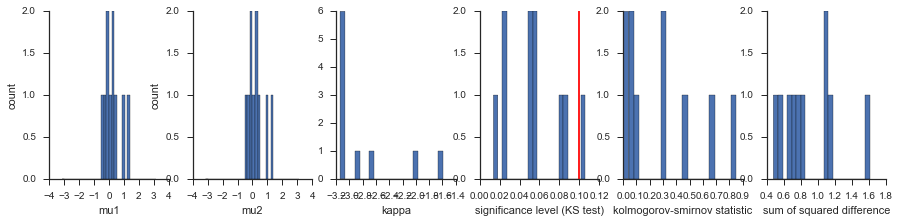

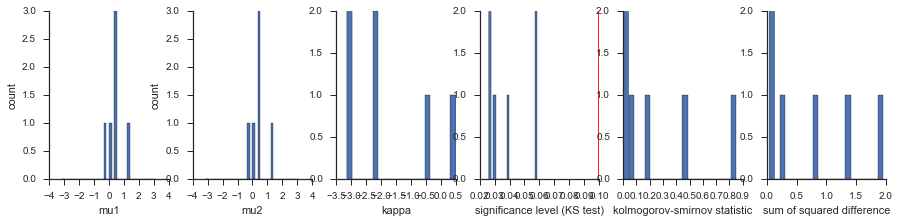

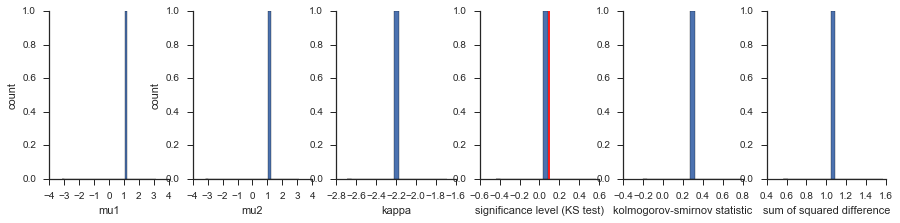

In [86]:
for scene in range(len(sceneNames)):
    sceneName = sceneNames[scene]
    fitFig = plt.figure(figsize=(15,3))

    bins = np.linspace(-np.pi, np.pi, 360/binwidth + 1)

    muax = fitFig.add_subplot(161)
    muax.hist(vmbmfits[scene,0,~np.isnan(vmbmfits[scene,0,:])],bins)
    muax.set_ylabel('count')
    muax.set_xlabel('mu1')
    myAxisTheme(muax)
    
    muax = fitFig.add_subplot(162)
    muax.hist(vmbmfits[scene,0,~np.isnan(vmbmfits[scene,1,:])],bins)
    muax.set_ylabel('count')
    muax.set_xlabel('mu2')
    myAxisTheme(muax)

    bins = np.linspace(0, 2, 21)
    kapax = fitFig.add_subplot(163)
    kapax.hist(vmbmfits[scene,1,~np.isnan(vmbmfits[scene,2,:])],len(bins))
    kapax.set_xlabel('kappa')
    myAxisTheme(kapax)

    bins = np.linspace(0, 1, 21)
    pax = fitFig.add_subplot(164)
    pax.hist(vmbmfits[scene,3,~np.isnan(vmbmfits[scene,4,:])],len(bins))
    #pax.set_xlim(0, 1)
    pax.axvline(0.1,color='red')
    pax.set_xlabel('significance level (KS test)')

    bins = np.linspace(0, 1, 21)
    ksax = fitFig.add_subplot(165)
    ksax.hist(vmbmfits[scene,4,~np.isnan(vmbmfits[scene,5,:])],len(bins))
    #ksax.set_xlim(0, 1)
    ksax.set_xlabel('kolmogorov-smirnov statistic')
    myAxisTheme(ksax)

    bins = np.linspace(0, 1, 21)
    ksax = fitFig.add_subplot(166)
    ksax.hist(vmbmfits[scene,2,~np.isnan(vmbmfits[scene,3,:])],len(bins))
    #ksax.set_xlim(0, 1)
    ksax.set_xlabel('sum of squared difference')
    myAxisTheme(ksax)

    print(sceneName)
    print('flies with heading distribution that is significantly different from von Mieses fit (KS test):')
    print([flyIDs[fly] for fly in np.where(vmbmfits[scene,4,:]<=0.1)[0]])

    myAxisTheme(pax)

    fitFig.savefig(analysisDir + 'circStats/'  + genotype + '_' + sceneName
                   + '_vMbiModFitDistributions_n'+ str(numFlies) +'.pdf', format='pdf') 

problem with sample
nan
problem with sample
nan


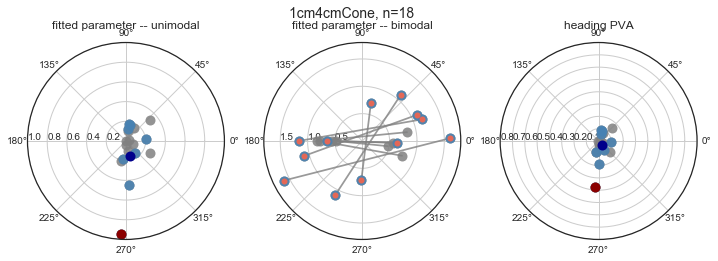

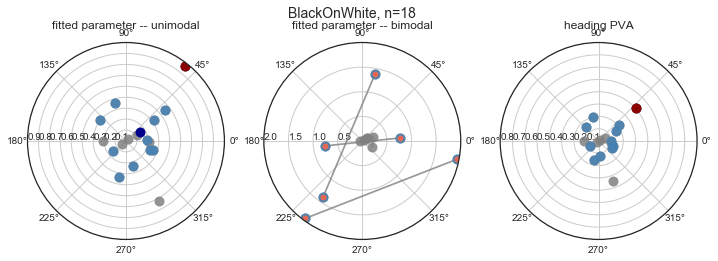

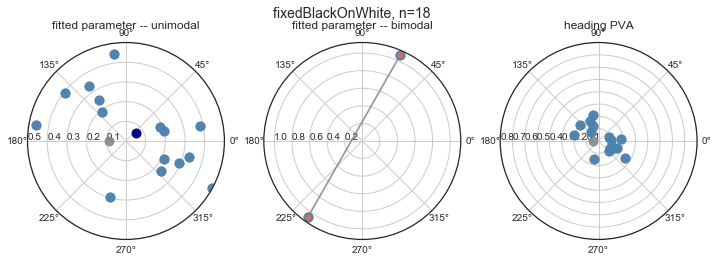

In [87]:
# number of flies with fitted von Mises with Kappa > 0.5 (disregarding also the flies that were not well represented by
# von Mises fit)

kappaTH = 0.5

for scene in range(len(sceneNames)):
    sceneName = sceneNames[scene]
    
    goodFit = np.logical_and(np.logical_or(vmfits[scene,3,:]>0.1, headingPVA[scene,:,1]>0.5),\
                              ~np.isnan(headingPVA[scene,:,1]))
    slct = np.logical_and(vmfits[scene,1,:]>kappaTH,goodFit)
    
    goodFit_bm = vmbmfits[scene,4,:]>0.1
    slct_bm = np.logical_and(vmbmfits[scene,2,:]>kappaTH,goodFit_bm)

    #Plot fit results
    fixFig = plt.figure(figsize=(12,4))
    fixFig.suptitle(sceneName+', n='+str(numFlies),fontsize=14)

    #polar plot of fitted location and shape parameter - unimodal
    ax = fixFig.add_subplot(131,projection='polar')
    ax.plot(vmfits[scene,0,:],vmfits[scene,1,:],'o',markersize=10,color='grey',alpha=0.85)
    ax.plot(vmfits[scene,0,goodFit],vmfits[scene,1,goodFit],'o',markersize=10,color='steelblue',alpha=0.85)
    meandir, meanlen = circmeanvec(vmfits[scene,0,goodFit],vmfits[scene,1,goodFit], high=angleHigh, low=angleLow)
    ax.plot(meandir,meanlen,'o', color='darkblue',alpha=1, markersize=10)
    
    ax.plot(vmfits[scene,0,slct],vmfits[scene,1,slct],'.',markersize=12,color='tomato',alpha=0.85)
    meandir, meanlen = circmeanvec(vmfits[scene,0,slct],vmfits[scene,1,slct], high=angleHigh, low=angleLow)
    ax.plot(meandir,meanlen,'o', color='darkred',alpha=1, markersize=10)
    #ax.set_rlim(0,np.nanmax(vmfits[:,1,:]))
    ax.set_rlabel_position(180)
    ax.set_title('fitted parameter -- unimodal')
    
    #polar plot of fitted location and shape parameter - bimodal
    ax = fixFig.add_subplot(132,projection='polar')
    ax.plot(vmbmfits[scene,0,:],vmbmfits[scene,2,:],'o',markersize=10,color='grey',alpha=0.85)
    ax.plot(vmbmfits[scene,1,:],vmbmfits[scene,2,:],'o',markersize=10,color='grey',alpha=0.85)
    ax.plot([vmbmfits[scene,0,:],vmbmfits[scene,1,:]],[vmbmfits[scene,2,:],vmbmfits[scene,2,:]],'-',color='grey',alpha=0.8)
    ax.plot(vmbmfits[scene,0,goodFit_bm],vmbmfits[scene,2,goodFit_bm],'o',markersize=10,color='steelblue',alpha=0.85)
    ax.plot(vmbmfits[scene,1,goodFit_bm],vmbmfits[scene,2,goodFit_bm],'o',markersize=10,color='steelblue',alpha=0.85)

    ax.plot(vmbmfits[scene,0,slct_bm],vmbmfits[scene,2,slct_bm],'.',markersize=12,color='tomato',alpha=0.85)
    ax.plot(vmbmfits[scene,1,slct_bm],vmbmfits[scene,2,slct_bm],'.',markersize=12,color='tomato',alpha=0.85)

    #ax.set_rlim(0,3)#np.nanmax(vmbmfits[:,2,:]))
    ax.set_rlabel_position(180)
    ax.set_title('fitted parameter -- bimodal')

    #polar plot of PVA
    ax = fixFig.add_subplot(133,projection='polar')
    ax.plot(headingPVA[scene,:,0],headingPVA[scene,:,1],'o',markersize=10,color='grey',alpha=0.85)
    ax.plot(headingPVA[scene,goodFit,0],headingPVA[scene,goodFit,1],'o',markersize=10,color='steelblue',alpha=0.85)
    meandir, meanlen = circmeanvec(headingPVA[scene,:,0],headingPVA[scene,:,1], high=angleHigh, low=angleLow)
    ax.plot(meandir,meanlen,'o', color='darkblue',alpha=1, markersize=10)

    ax.plot(headingPVA[scene,slct,0],headingPVA[scene,slct,1],'.',markersize=12,color='tomato',alpha=0.85)
    meandir, meanlen = circmeanvec(headingPVA[scene,slct,0],headingPVA[scene,slct,1], high=angleHigh, low=angleLow)
    ax.plot(meandir,meanlen,'o', color='darkred',alpha=1, markersize=10)
    ax.set_rlim(0,0.8)
    ax.set_rlabel_position(180)
    ax.set_title('heading PVA')
    
    #fixFig.tight_layout()
    fixFig.savefig(analysisDir + 'circStats/'  + genotype + '_' + sceneName
                   + '_vMBiModFixation_n'+ str(numFlies) +'.pdf', format='pdf') 
    
    np.savetxt(analysisDir + 'circStats/'  + genotype + '_vMFixation_'+sceneName+'_n'+ str(numFlies) +'.csv',
           np.c_[vmfits[scene,0,:],vmfits[scene,1,:],goodFit,
            vmbmfits[scene,0,:],vmbmfits[scene,1,:],vmbmfits[scene,2,:],goodFit_bm],
            delimiter=',', header='mu,kappa,gof,mu1_bm,mu2_bm,kappa_bm,gof_bm')
    

problem with sample
nan


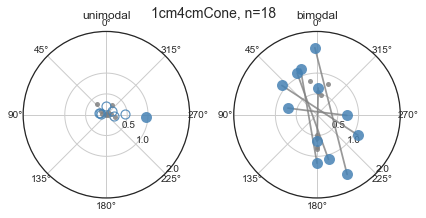

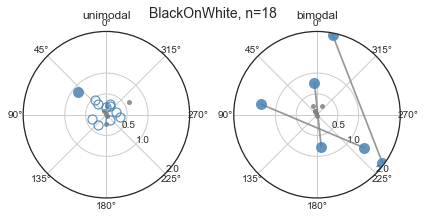

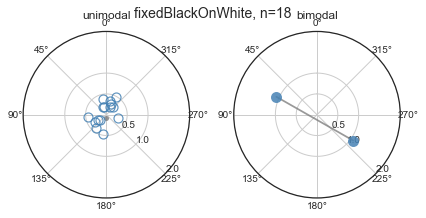

In [96]:
# number of flies with fitted von Mises with Kappa > 0.5 (disregarding also the flies that were not well represented by
# von Mises fit)

kappaTH = 0.5
sceneYLim = [2,2,2]

for scene in range(len(sceneNames)):
    sceneName = sceneNames[scene]
    
    goodFit = np.logical_and(np.logical_or(vmfits[scene,3,:]>0.1, headingPVA[scene,:,1]>0.5),\
                              ~np.isnan(headingPVA[scene,:,1]))
    slct = np.logical_and(vmfits[scene,1,:]>kappaTH,goodFit)
    gfplt = np.logical_and(goodFit, ~slct)
    
    goodFit_bm = vmbmfits[scene,4,:]>0.1
    slct_bm = np.logical_and(vmbmfits[scene,2,:]>kappaTH,goodFit_bm)
    gfplt_bm = np.logical_and(goodFit_bm, ~slct_bm)

    #Plot fit results
    fixFig = plt.figure(figsize=(6,3))
    fixFig.suptitle(sceneName+', n='+str(numFlies),fontsize=14)

    #polar plot of fitted location and shape parameter - unimodal
    ax = fixFig.add_subplot(121,projection='polar')
    ax.plot(vmfits[scene,0,~goodFit],vmfits[scene,1,~goodFit],'.',markersize=10,color='grey',alpha=0.85)
    ax.plot(vmfits[scene,0,gfplt],vmfits[scene,1,gfplt],'o',markeredgecolor='steelblue',
            markerfacecolor='none',  markeredgewidth=1.2, markersize = 9,alpha=0.85)
    ax.plot(vmfits[scene,0,slct],vmfits[scene,1,slct],'o',markersize=11,color='steelblue',alpha=0.85)
    meandir, meanlen = circmeanvec(vmfits[scene,0,slct],vmfits[scene,1,slct], high=angleHigh, low=angleLow)
    ax.plot(meandir,meanlen,'x', color='darkred',alpha=1, markersize=10)

    ax.set_title('unimodal')
    ax.set_rlabel_position(225)
    ax.set_yticks([0.5, 1, 2, 3])
    ax.set_ylim(0, sceneYLim[scene])
    ax.set_theta_zero_location("N")
    
    #polar plot of fitted location and shape parameter - bimodal
    ax = fixFig.add_subplot(122,projection='polar')
    ax.plot(vmbmfits[scene,0,~goodFit_bm],vmbmfits[scene,2,~goodFit_bm],'.',markersize=10,color='grey',alpha=0.85)
    ax.plot(vmbmfits[scene,1,~goodFit_bm],vmbmfits[scene,2,~goodFit_bm],'.',markersize=10,color='grey',alpha=0.85)
    ax.plot([vmbmfits[scene,0,goodFit_bm],vmbmfits[scene,1,goodFit_bm]],
            [vmbmfits[scene,2,goodFit_bm],vmbmfits[scene,2,goodFit_bm]],'-',color='grey',alpha=0.8)
    ax.plot(vmbmfits[scene,0,gfplt_bm],vmbmfits[scene,2,gfplt_bm],'o',color='steelblue',markerfacecolor='none', 
            markeredgewidth=1.2, markersize = 9,alpha=0.85)
    ax.plot(vmbmfits[scene,1,gfplt_bm],vmbmfits[scene,2,gfplt_bm],'o',color='steelblue',markerfacecolor='none', 
            markeredgewidth=1.2, markersize = 9,alpha=0.85)
    ax.plot(vmbmfits[scene,0,slct_bm],vmbmfits[scene,2,slct_bm],'o',markersize=11,color='steelblue',alpha=0.85)
    ax.plot(vmbmfits[scene,1,slct_bm],vmbmfits[scene,2,slct_bm],'o',markersize=11,color='steelblue',alpha=0.85)

    ax.set_title('bimodal')
    ax.set_rlabel_position(225)
    ax.set_yticks([0.5, 1, 2, 3])
    ax.set_ylim(0, sceneYLim[scene])
    ax.set_theta_zero_location("N")
    
    fixFig.tight_layout()
    fixFig.savefig(analysisDir + 'circStats/'  + genotype + '_' + sceneName
                   + '_vMBiModFixation_v2_n'+ str(numFlies) +'.pdf', format='pdf') 

problem with sample
nan


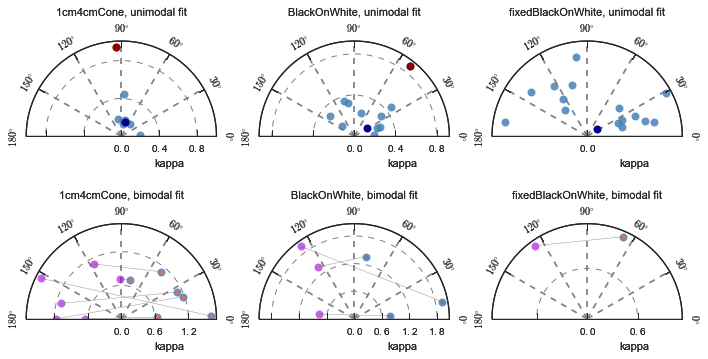

In [89]:
# number of flies with fitted von Mises with Kappa > 0.5 (disregarding also the flies that were not well represented by
# von Mises fit)

kappaTH = 0.5

fixFig = plt.figure(figsize=(16,6))

for scene, sceneName in enumerate(sceneNames):
    
    goodFit = np.logical_and(np.logical_or(vmfits[scene,3,:]>0.1, headingPVA[scene,:,1]>0.5),\
                              ~np.isnan(headingPVA[scene,:,1]))
    slct = np.logical_and(vmfits[scene,1,:]>kappaTH,goodFit)
    
    goodFit_bm = vmbmfits[scene,4,:]>0.1
    slct_bm = np.logical_and(vmbmfits[scene,2,:]>kappaTH,goodFit_bm)

    #polar plot of fitted location and shape parameter - unimodal
    polplt = fractional_polar_axes(fixFig, thlim=(0, 180), rlim=(0, 1.06*np.nanmax(vmfits[scene,1,goodFit])),
                                   step=(30, 0.3), thlabel = sceneName+', unimodal fit',
                                   rlabel='kappa',subplotloc='24'+str(scene+1))
    polplt.plot(abs(vmfits[scene,0,goodFit])*180/np.pi,vmfits[scene,1,goodFit],'o',markersize=8,color='steelblue',alpha=0.85)
    meandir, meanlen = circmeanvec(vmfits[scene,0,goodFit],vmfits[scene,1,goodFit], high=angleHigh, low=angleLow)
    polplt.plot(abs(meandir)*180/np.pi,meanlen,'o', color='darkblue',alpha=1, markersize=8)
    
    polplt.plot(abs(vmfits[scene,0,slct])*180/np.pi,vmfits[scene,1,slct],'.',markersize=10,color='tomato',alpha=0.85)
    meandir, meanlen = circmeanvec(vmfits[scene,0,slct],vmfits[scene,1,slct], high=angleHigh, low=angleLow)
    polplt.plot(abs(meandir)*180/np.pi,meanlen,'o', color='darkred',alpha=1, markersize=8)
    
    #polar plot of fitted location and shape parameter - bimodal
    if sum(goodFit_bm):
        polplt = fractional_polar_axes(fixFig, thlim=(0, 180), rlim=(0, 1.06*np.nanmax(vmbmfits[scene,2,goodFit_bm])),
                                       step=(30, 0.5), thlabel = sceneName+', bimodal fit', 
                                       rlabel='kappa', subplotloc='24'+str(scene+5))
    
        polplt.plot(np.abs(vmbmfits[scene,0,goodFit_bm])*180.0/np.pi,vmbmfits[scene,2,goodFit_bm],'o',markersize=8,color='steelblue',alpha=0.85)
        polplt.plot(np.abs(vmbmfits[scene,1,goodFit_bm])*180.0/np.pi,vmbmfits[scene,2,goodFit_bm],'o',markersize=8,color='darkviolet',alpha=0.6)
    

        polplt.plot([np.abs(vmbmfits[scene,0,goodFit_bm])*180/np.pi,np.abs(vmbmfits[scene,1,goodFit_bm])*180/np.pi],
                    [vmbmfits[scene,2,goodFit_bm],vmbmfits[scene,2,goodFit_bm]],
                    '-',linewidth = 0.5, color='grey',alpha=0.8)

        polplt.plot(np.abs(vmbmfits[scene,0,slct_bm])*180.0/np.pi,vmbmfits[scene,2,slct_bm],'.',markersize=8,
                    color='tomato',alpha=0.85)

#fixFig.tight_layout()
#fixFig.savefig(analysisDir + 'circStats/'  + genotype
#               + '_vMBiModFixation3_n'+ str(numFlies) +'.pdf', format='pdf') 

### Selection of data

In [90]:
print('Total number of flies measured: ' + str(numFlies))

for scene,sceneName in enumerate(sceneNames):
    print('\n'+sceneName)
    
    goodFit = np.logical_and(np.logical_or(vmfits[scene,3,:]>0.1, headingPVA[scene,:,1]>0.5),\
                              ~np.isnan(headingPVA[scene,:,1]))
    slct = np.logical_and(vmfits[scene,1,:]>kappaTH,goodFit)
    
    goodFit_bm = vmbmfits[scene,4,:]>0.1
    
    slct_bm = np.logical_and(vmbmfits[scene,2,:]>kappaTH,goodFit_bm)
    
    print('Number of flies that walked for less than 20% of trial time: ' + str(int(fliesNotWalking[scene])) \
          + ' ('+str(numFlies)+')')
    
    print('Unimodal fits:')
    print('  Number of walking flies for which von Mises was good fit: ' + str(sum(goodFit))\
          + ' ('+str(numFlies-int(fliesNotWalking[scene]))+')')
    print('  Total number of fitted distributions with concentration measure kappa > '+str(kappaTH)+': '\
          +str(sum(vmfits[scene,1,:]>kappaTH)) + ' ('+str(numFlies-int(fliesNotWalking[scene]))+')')
    print('  Number of well fitted distributions with concentration measure kappa > '+str(kappaTH)+': '\
          +str(sum(vmfits[scene,1,goodFit]>kappaTH)) + ' ('+str(sum(goodFit))+')')

    print('Bimodal fits:')
    print('  Number of walking flies for which bimodal von Mises was good fit: ' + str(sum(goodFit_bm))\
          + ' ('+str(sum(~goodFit)-int(fliesNotWalking[scene]))+')')
    print('  Number of well fitted distributions with concentration measure kappa > '+str(kappaTH)+': '\
          +str(sum(vmbmfits[scene,2,goodFit_bm]>kappaTH)) + ' ('+str(sum(goodFit_bm))+')')

Total number of flies measured: 18

1cm4cmCone
Number of flies that walked for less than 20% of trial time: 0 (18)
Unimodal fits:
  Number of walking flies for which von Mises was good fit: 8 (18)
  Total number of fitted distributions with concentration measure kappa > 0.5: 1 (18)
  Number of well fitted distributions with concentration measure kappa > 0.5: 1 (8)
Bimodal fits:
  Number of walking flies for which bimodal von Mises was good fit: 6 (10)
  Number of well fitted distributions with concentration measure kappa > 0.5: 6 (6)

BlackOnWhite
Number of flies that walked for less than 20% of trial time: 1 (18)
Unimodal fits:
  Number of walking flies for which von Mises was good fit: 11 (17)
  Total number of fitted distributions with concentration measure kappa > 0.5: 2 (17)
  Number of well fitted distributions with concentration measure kappa > 0.5: 1 (11)
Bimodal fits:
  Number of walking flies for which bimodal von Mises was good fit: 3 (6)
  Number of well fitted distribution

### Use Rayleigh test on mean fixation location (on selected data, conditioned on good fit with unimodal von Mises)

In [91]:
# ...based on on fitted location parameter mu

for scene in range(len(sceneNames)):
    sceneName = sceneNames[scene]
    print('\n'+sceneName)
    
    goodFit = np.logical_and(np.logical_or(vmfits[scene,3,:]>0.1, headingPVA[scene,:,1]>0.5),\
                              ~np.isnan(headingPVA[scene,:,1]))
    
    slct = np.logical_and(vmfits[scene,1,:]>kappaTH,goodFit)

    fitSamples = len(vmfits[scene,0,slct])
    
    PVAdir, PVAlen = circmeanvec(vmfits[scene,0,slct],np.ones(fitSamples), high=angleHigh, low=angleLow)

    [z,p] = RayleighTest(PVAlen,fitSamples)

    print('Test statistic z = ' + str(z))
    print('Probability of test statistic p = ' + str(p))
    if (p<0.001):
        print('Reject H0 that sample is drawn from a uniform distribution (p<0.001).')
        print('Mean angle = ' + str(round(PVAdir,3)) + ' ('+ str(round(PVAdir*180/np.pi,3))+' deg)')
    elif (p<0.01): 
        print('Reject H0 that sample is drawn from a uniform distribution (p<0.01).')
        print('Mean angle = ' + str(round(PVAdir,3)) + ' ('+ str(round(PVAdir*180/np.pi,3))+' deg)')
    elif (p<0.05): 
        print('Reject H0 that sample is drawn from a uniform distribution (p<0.05).')
        print('Mean angle = ' + str(round(PVAdir,3)) + ' ('+ str(round(PVAdir*180/np.pi,3))+' deg)')
    else:
        print('Accept H0 that sample is drawn from a uniform distribution (p>0.01).')


1cm4cmCone
Test statistic z = 1.0
Probability of test statistic p = 0.465831162611
Accept H0 that sample is drawn from a uniform distribution (p>0.01).

BlackOnWhite
Test statistic z = 1.0
Probability of test statistic p = 0.465831162611
Accept H0 that sample is drawn from a uniform distribution (p>0.01).

fixedBlackOnWhite
problem with sample
nan
Test statistic z = nan
Probability of test statistic p = nan
Accept H0 that sample is drawn from a uniform distribution (p>0.01).


## Comparison between fixation in 1D and 2D
### Is there a correlation between the location of the fixation peak in 1D and 2D?

In [92]:
sceneNames

['1cm4cmCone', 'BlackOnWhite', 'fixedBlackOnWhite']

fixedBlackOnWhite vs 1cm4cmCone
BlackOnWhite vs 1cm4cmCone


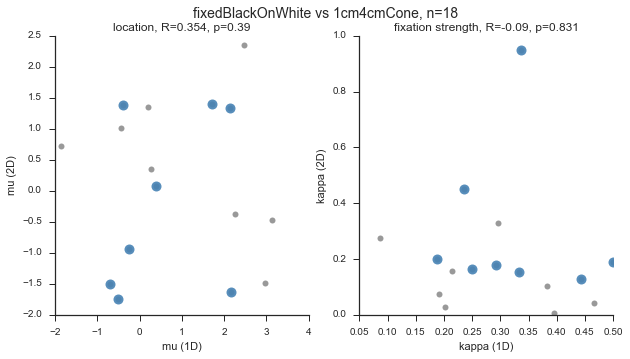

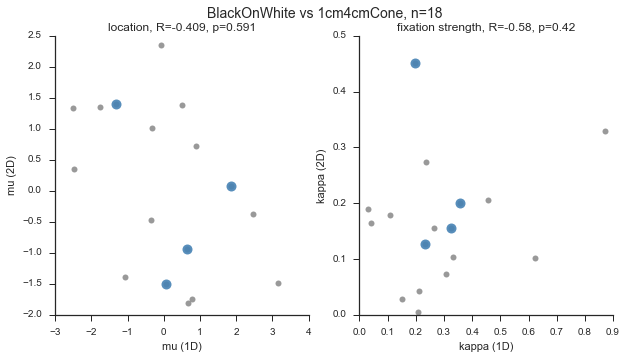

In [93]:
# number of flies with fitted von Mises with Kappa > 0.5 (disregarding also the flies that were not well represented by
# von Mises fit)

kappaTH = 0.5

groups = [(0,2), (0,1)]

for ind, group in enumerate(groups):
    scene1D = sceneNames[group[1]]
    scene2D = sceneNames[group[0]]
    
    print(scene1D + ' vs ' + scene2D)
    
    #Plot fit results
    fix1Dvs2DFig = plt.figure(figsize=(10,5))
    fix1Dvs2DFig.suptitle(scene1D + ' vs ' + scene2D + ', n='+str(numFlies),fontsize=14)
    
    ## Unimodal
    goodFit1D = np.logical_and(np.logical_or(vmfits[group[1],3,:]>0.1, headingPVA[group[1],:,1]>0.5),\
                              ~np.isnan(headingPVA[group[1],:,1]))
    goodFit2D = np.logical_and(np.logical_or(vmfits[group[0],3,:]>0.1, headingPVA[group[0],:,1]>0.5),\
                              ~np.isnan(headingPVA[group[0],:,1]))
    goodFit = np.logical_and(goodFit1D,goodFit2D)
    
    slct1D = np.logical_and(vmfits[group[1],1,:]>kappaTH,goodFit1D)
    slct2D = np.logical_and(vmfits[group[0],1,:]>kappaTH,goodFit2D)
    slct = np.logical_and(slct1D,slct2D)

    #correlation between fixation location in 1D and 2D
    ax = fix1Dvs2DFig.add_subplot(121)
    ax.plot(vmfits[group[1],0,:],vmfits[group[0],0,:],'o',markersize=6,color='grey',alpha=0.8)
    ax.plot(vmfits[group[1],0,goodFit],vmfits[group[0],0,goodFit],'o',markersize=10,color='steelblue',alpha=0.9)
    ax.plot(vmfits[group[1],0,slct],vmfits[group[0],0,slct],'.',markersize=12,color='tomato',alpha=0.7)
    ax.set_xlabel('mu (1D)')
    ax.set_ylabel('mu (2D)')
    pR, pp = sts.pearsonr(vmfits[group[1],0,goodFit], vmfits[group[0],0,goodFit])
    ax.set_title('location, R='+str(round(pR,3))+', p='+str(round(pp,3)))
    myAxisTheme(ax)
    
    #correlation between fixation strength in 1D and 2D
    ax = fix1Dvs2DFig.add_subplot(122)
    ax.plot(vmfits[group[1],1,:],vmfits[group[0],1,:],'o',markersize=6,color='grey',alpha=0.8)
    ax.plot(vmfits[group[1],1,goodFit],vmfits[group[0],1,goodFit],'o',markersize=10,color='steelblue',alpha=0.9)
    ax.plot(vmfits[group[1],1,slct],vmfits[group[0],1,slct],'.',markersize=12,color='tomato',alpha=0.7)
    ax.set_xlabel('kappa (1D)')
    ax.set_ylabel('kappa (2D)')
    pR, pp = sts.pearsonr(vmfits[group[1],1,goodFit], vmfits[group[0],1,goodFit])
    ax.set_title('fixation strength, R='+str(round(pR,3))+', p='+str(round(pp,3)))
    myAxisTheme(ax)
    
    fix1Dvs2DFig.savefig(analysisDir + 'circStats/'  + genotype + '_' + scene1D + 'Vs' + scene2D
                   + '-Fixation_n'+ str(numFlies) +'.pdf', format='pdf') 

## Intergroup comparison -- uses saved data in csv file

In [92]:
dataDir = sep.join(analysisDir.split(sep)[:-5]) + '/'
groupFile = 'WTB_vMFixation_allData' #'allGentype_vMFixation_highT-cut' # 
fitdata_df = pd.read_csv(dataDir + groupFile + '.csv')
fitdata_df

genotype         group  wings room temp     sex scene      contrast  \
0        WTB    high-T-cut    cut      high    male    1D  darkOnBright   
1        WTB    high-T-cut    cut      high    male    1D  darkOnBright   
2        WTB    high-T-cut    cut      high    male    1D  darkOnBright   
3        WTB    high-T-cut    cut      high    male    1D  darkOnBright   
4        WTB    high-T-cut    cut      high    male    1D  darkOnBright   
5        WTB    high-T-cut    cut      high    male    1D  darkOnBright   
6        WTB    high-T-cut    cut      high    male    1D  darkOnBright   
7        WTB    high-T-cut    cut      high    male    1D  darkOnBright   
8        WTB    high-T-cut    cut      high    male    1D  darkOnBright   
9        WTB    high-T-cut    cut      high    male    1D  darkOnBright   
10       WTB    high-T-cut    cut      high    male    1D  darkOnBright   
11       WTB    high-T-cut    cut      high    male    1D  darkOnBright   
12       WTB    high-T-cut    cut      high    male    1D  darkOnBright   
13       WTB    high-T-cut    cut      high    male    1D  darkOnBright   
14       WTB    high-T-cut    cut      high    male    1D  darkOnBright   
15       WTB    high-T-cut    cut      high    male    1D  darkOnBright   
16       WTB    high-T-cut    cut      high    male    2D  darkOnBright   
17       WTB    high-T-cut    cut      high    male    2D  darkOnBright   
18       WTB    high-T-cut    cut      high    male    2D  darkOnBright   
19       WTB    high-T-cut    cut      high    male    2D  darkOnBright   
20       WTB    high-T-cut    cut      high    male    2D  darkOnBright   
21       WTB    high-T-cut    cut      high    male    2D  darkOnBright   
22       WTB    high-T-cut    cut      high    male    2D  darkOnBright   
23       WTB    high-T-cut    cut      high    male    2D  darkOnBright   
24       WTB    high-T-cut    cut      high    male    2D  darkOnBright   
25       WTB    high-T-cut    cut      high    male    2D  darkOnBright   
26       WTB    high-T-cut    cut      high    male    2D  darkOnBright   
27       WTB    high-T-cut    cut      high    male    2D  darkOnBright   
28       WTB    high-T-cut    cut      high    male    2D  darkOnBright   
29       WTB    high-T-cut    cut      high    male    2D  darkOnBright   
..       ...           ...    ...       ...     ...   ...           ...   
458      WTB  high-T-glued  glued      high  female    1D  brightOnDark   
459      WTB  high-T-glued  glued      high  female    1D  brightOnDark   
460      WTB  high-T-glued  glued      high  female    1D  brightOnDark   
461      WTB  high-T-glued  glued      high  female    1D  brightOnDark   
462      WTB  high-T-glued  glued      high  female    1D  brightOnDark   
463      WTB  high-T-glued  glued      high  female    1D  brightOnDark   
464      WTB  high-T-glued  glued      high  female    1D  brightOnDark   
465      WTB  high-T-glued  glued      high  female    1D  brightOnDark   
466      WTB  high-T-glued  glued      high  female    1D  brightOnDark   
467      WTB  high-T-glued  glued      high  female    1D  brightOnDark   
468      WTB  high-T-glued  glued      high  female    1D  brightOnDark   
469      WTB  high-T-glued  glued      high  female    1D  brightOnDark   
470      WTB  high-T-glued  glued      high  female    2D  brightOnDark   
471      WTB  high-T-glued  glued      high  female    2D  brightOnDark   
472      WTB  high-T-glued  glued      high  female    2D  brightOnDark   
473      WTB  high-T-glued  glued      high  female    2D  brightOnDark   
474      WTB  high-T-glued  glued      high  female    2D  brightOnDark   
475      WTB  high-T-glued  glued      high  female    2D  brightOnDark   
476      WTB  high-T-glued  glued      high  female    2D  brightOnDark   
477      WTB  high-T-glued  glued      high  female    2D  brightOnDark   
478      WTB  high-T-glued  glued      high  female    2D  brightOnDark   
479      WTB  high-T-glued  g

In [93]:
fitdata_df["genotype"] = fitdata_df["genotype"].astype('category')
fitdata_df["wings"] = fitdata_df["wings"].astype('category')
fitdata_df["room temp"] = fitdata_df["room temp"].astype('category')
fitdata_df["sex"] = fitdata_df["sex"].astype('category')
fitdata_df["scene"] = fitdata_df["scene"].astype('category')
fitdata_df["contrast"] = fitdata_df["contrast"].astype('category')
fitdata_df["sceneName"] = fitdata_df["sceneName"].astype('category')
fitdata_df["group"] = fitdata_df["group"].astype('category')

dict(enumerate(fitdata_df.group.cat.categories) )

{0: 'high-T-cut', 1: 'high-T-glued', 2: 'low-T-cut'}

### Visualisation with ggplot and R magic

In [94]:
fitdata_df

genotype         group  wings room temp     sex scene      contrast  \
0        WTB    high-T-cut    cut      high    male    1D  darkOnBright   
1        WTB    high-T-cut    cut      high    male    1D  darkOnBright   
2        WTB    high-T-cut    cut      high    male    1D  darkOnBright   
3        WTB    high-T-cut    cut      high    male    1D  darkOnBright   
4        WTB    high-T-cut    cut      high    male    1D  darkOnBright   
5        WTB    high-T-cut    cut      high    male    1D  darkOnBright   
6        WTB    high-T-cut    cut      high    male    1D  darkOnBright   
7        WTB    high-T-cut    cut      high    male    1D  darkOnBright   
8        WTB    high-T-cut    cut      high    male    1D  darkOnBright   
9        WTB    high-T-cut    cut      high    male    1D  darkOnBright   
10       WTB    high-T-cut    cut      high    male    1D  darkOnBright   
11       WTB    high-T-cut    cut      high    male    1D  darkOnBright   
12       WTB    high-T-cut    cut      high    male    1D  darkOnBright   
13       WTB    high-T-cut    cut      high    male    1D  darkOnBright   
14       WTB    high-T-cut    cut      high    male    1D  darkOnBright   
15       WTB    high-T-cut    cut      high    male    1D  darkOnBright   
16       WTB    high-T-cut    cut      high    male    2D  darkOnBright   
17       WTB    high-T-cut    cut      high    male    2D  darkOnBright   
18       WTB    high-T-cut    cut      high    male    2D  darkOnBright   
19       WTB    high-T-cut    cut      high    male    2D  darkOnBright   
20       WTB    high-T-cut    cut      high    male    2D  darkOnBright   
21       WTB    high-T-cut    cut      high    male    2D  darkOnBright   
22       WTB    high-T-cut    cut      high    male    2D  darkOnBright   
23       WTB    high-T-cut    cut      high    male    2D  darkOnBright   
24       WTB    high-T-cut    cut      high    male    2D  darkOnBright   
25       WTB    high-T-cut    cut      high    male    2D  darkOnBright   
26       WTB    high-T-cut    cut      high    male    2D  darkOnBright   
27       WTB    high-T-cut    cut      high    male    2D  darkOnBright   
28       WTB    high-T-cut    cut      high    male    2D  darkOnBright   
29       WTB    high-T-cut    cut      high    male    2D  darkOnBright   
..       ...           ...    ...       ...     ...   ...           ...   
458      WTB  high-T-glued  glued      high  female    1D  brightOnDark   
459      WTB  high-T-glued  glued      high  female    1D  brightOnDark   
460      WTB  high-T-glued  glued      high  female    1D  brightOnDark   
461      WTB  high-T-glued  glued      high  female    1D  brightOnDark   
462      WTB  high-T-glued  glued      high  female    1D  brightOnDark   
463      WTB  high-T-glued  glued      high  female    1D  brightOnDark   
464      WTB  high-T-glued  glued      high  female    1D  brightOnDark   
465      WTB  high-T-glued  glued      high  female    1D  brightOnDark   
466      WTB  high-T-glued  glued      high  female    1D  brightOnDark   
467      WTB  high-T-glued  glued      high  female    1D  brightOnDark   
468      WTB  high-T-glued  glued      high  female    1D  brightOnDark   
469      WTB  high-T-glued  glued      high  female    1D  brightOnDark   
470      WTB  high-T-glued  glued      high  female    2D  brightOnDark   
471      WTB  high-T-glued  glued      high  female    2D  brightOnDark   
472      WTB  high-T-glued  glued      high  female    2D  brightOnDark   
473      WTB  high-T-glued  glued      high  female    2D  brightOnDark   
474      WTB  high-T-glued  glued      high  female    2D  brightOnDark   
475      WTB  high-T-glued  glued      high  female    2D  brightOnDark   
476      WTB  high-T-glued  glued      high  female    2D  brightOnDark   
477      WTB  high-T-glued  glued      high  female    2D  brightOnDark   
478      WTB  high-T-glued  glued      high  female    2D  brightOnDark   
479      WTB  high-T-glued  g

In [95]:
# enable R Kernel 
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


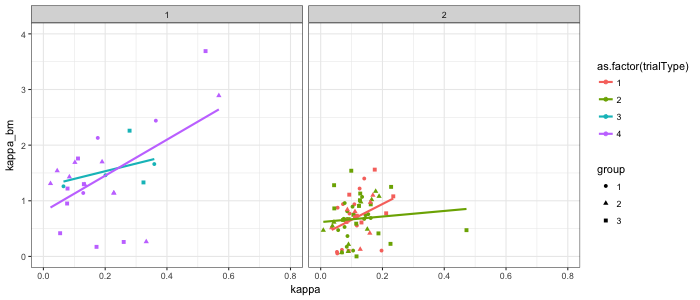

In [154]:
%%R -i fitdata_df -w 700 -h 300 -u px

library(ggplot2)

x <- ggplot(fitdata_df, aes(x=kappa, y=kappa_bm, color=as.factor(trialType))) + 
     geom_point(aes(shape=group)) + geom_smooth(method=lm,se=FALSE,fullrange=FALSE) +
     facet_grid(. ~ contrast) +
     xlim(0, 0.8) + ylim(0, 4) + theme_bw()
print(x)

for (trial in c(1,2,3,4)){
    scene1dat_df <- subset(fitdata_df, trialType==trial)

    lmfit <- lm(kappa_bm ~ kappa, data = scene1dat_df)
    summary(lmfit)
}

In [150]:
%%R -i fitdata_df -w 700 -h 300 -u px

trial <- 4
scene1dat_df <- subset(fitdata_df, trialType==trial)

lmfit <- lm(kappa_bm ~ kappa, data = scene1dat_df)
s <- capture.output(summary(lmfit))

In [151]:
#trial 4
a =%R s
for line in a:
    print(line)


Call:
lm(formula = kappa_bm ~ kappa, data = scene1dat_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.20954 -0.36133 -0.07142  0.32933  2.17342 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.3157     0.2195   5.995 7.32e-06 ***
kappa         0.3826     0.4563   0.838    0.412    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8491 on 20 degrees of freedom
  (100 observations deleted due to missingness)
Multiple R-squared:  0.03396,	Adjusted R-squared:  -0.01434 
F-statistic: 0.703 on 1 and 20 DF,  p-value: 0.4117



In [149]:
#trial 3
a =%R s
for line in a:
    print(line)


Call:
lm(formula = kappa_bm ~ kappa, data = scene1dat_df)

Residuals:
      37       39      101      105      205      309 
-0.07709 -0.06651 -0.11404 -0.01721  0.62940 -0.35455 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)   1.2961     0.2681   4.835  0.00843 **
kappa         1.1989     0.6526   1.837  0.14009   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3693 on 4 degrees of freedom
  (116 observations deleted due to missingness)
Multiple R-squared:  0.4576,	Adjusted R-squared:  0.322 
F-statistic: 3.375 on 1 and 4 DF,  p-value: 0.1401



In [147]:
#trial 2
a =%R s
for line in a:
    print(line)


Call:
lm(formula = kappa_bm ~ kappa, data = scene1dat_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.67433 -0.24898  0.00762  0.26743  0.87346 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.6170     0.1085   5.687 1.21e-06 ***
kappa         0.5007     0.7748   0.646    0.522    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3727 on 41 degrees of freedom
  (79 observations deleted due to missingness)
Multiple R-squared:  0.01008,	Adjusted R-squared:  -0.01406 
F-statistic: 0.4176 on 1 and 41 DF,  p-value: 0.5217



In [145]:
#trial 1
a =%R s
for line in a:
    print(line)


Call:
lm(formula = kappa_bm ~ kappa, data = scene1dat_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.82825 -0.25246  0.03179  0.24791  0.68912 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)   0.3748     0.1912    1.96   0.0608 .
kappa         2.8350     1.5078    1.88   0.0713 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3934 on 26 degrees of freedom
  (94 observations deleted due to missingness)
Multiple R-squared:  0.1197,	Adjusted R-squared:  0.08583 
F-statistic: 3.535 on 1 and 26 DF,  p-value: 0.07133



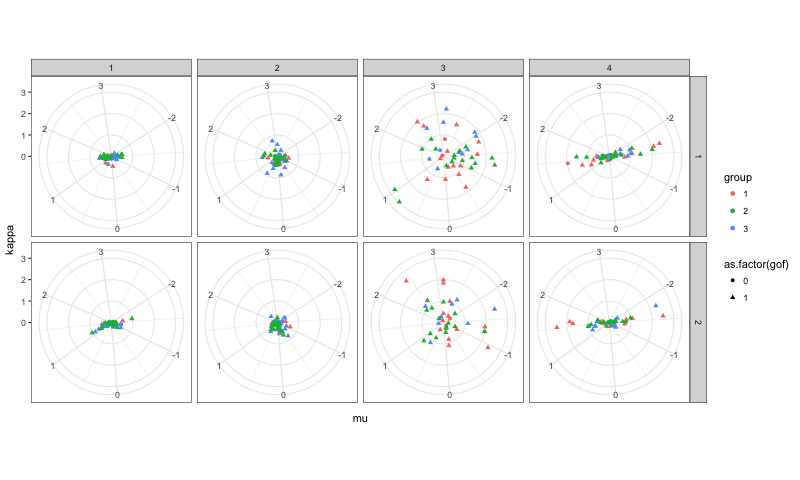

In [96]:
%%R -i fitdata_df -w 800 -h 480 -u px

library(ggplot2)

x <- ggplot(fitdata_df, aes(x=mu, y=kappa, color=group, shape=as.factor(gof))) + geom_point() + coord_polar() + facet_grid(sex ~ sceneName)
x <- x + ylim(0, 3) + theme_bw()
print(x)

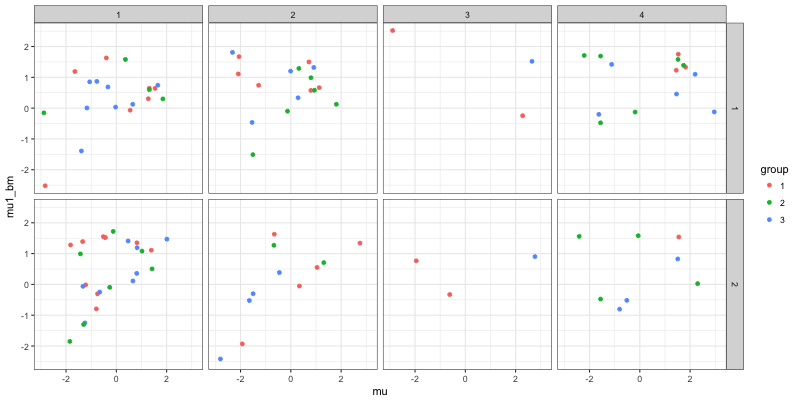

In [148]:
%%R -i fitdata_df -w 800 -h 400 -u px

y <- ggplot(fitdata_df, aes(x=mu, y=mu1_bm, color=group)) + geom_point() + facet_grid(sex ~ sceneName)
y <- y + theme_bw()
print(y)